In [293]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd 
import openpyxl
import numpy as np
import re
from collections import deque, defaultdict
from unicodedata import normalize
import itertools
import math

import seaborn as sns
import matplotlib
# import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'IPAexGothic'
import numpy as np
plt.style.use('seaborn')
import japanize_matplotlib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
curr_dir = os.path.realpath('.')

In [30]:
filename = "./data/MASTER/マスタデータセット_230214結果_飯野修正版.xlsx"

In [31]:
df = pd.read_excel(filename, sheet_name="車名xメーカーxBTxエンジン", skiprows=1)

In [32]:
merge_table_df = pd.read_excel(filename, sheet_name="マージ燃費車名xメーカーxBTxエンジン", skiprows=1)
merge_table_df = merge_table_df[~pd.isna(merge_table_df["メーカー"])]

In [33]:
merge_table_df.columns

Index(['メーカー', 'ボディタイプ', 'エンジンタイプ', 'BT', 'エンジンタイプ修正後', 'メーカー.1',
       'ガソリンorハイブリッド', 'レコード重複フラグ', '車名数', '車名数.1', '合計 /  SUM(台数)', '距離',
       '燃費_平均値(平均)', '燃費_平均値(中央)', '燃費_中央値(平均)', '燃費_中央値(中央)', 'CO2計算',
       '計算対象外フラグ', 'Sim可能組み合わせ', '計算対象外', 'Unnamed: 20', 'Unnamed: 21'],
      dtype='object')

In [34]:
count_df = pd.read_excel(filename, sheet_name="台数", skiprows=7)

In [35]:
count_df.columns

Index(['No', '商企クラス区分', '商企市場区分名称', 'カテゴリ（国内営業）名称',
       'カテゴリ･クラス（国内営業）名称 ＊カテゴリと併用の事', 'ボディタイプ', 'メーカーブランド', 'メーカー', '車名通称名称',
       '年月', '燃料系', 'エンジンタイプ', '用途', '相対年式', '新中区分', ' SUM(台数)', 'Unnamed: 16',
       'Unnamed: 17'],
      dtype='object')

In [36]:
distance_df = pd.read_excel(filename, sheet_name="走行距離_ケース4", skiprows=0) 
distance_df.columns

Index([    'No',     'BT',   'エンジン',   'メーカー',   'WB ｎ',     1800,     5400,
           9000,    12600,    16200,    19800,    23400,    27000,    30600,
          34200,    37800,    41400, '年間走行距離'],
      dtype='object')

In [37]:
nenpi_df = pd.read_excel(filename, sheet_name="燃費_230118", skiprows=3) 
nenpi_df.columns

Index(['No', '年', '燃料区分', '型区分', 'モード', '車名', '通称名', '※全て半角にした(asc)',
       '※前後の空白を除去した(trim)', 'ハイブリッドフラグ', 'ガソリン/ハイブリッド', '原動機/型式',
       '原動機/総排気量(L)', '車両重量（kg）', '燃費値（km/L）', '1km走行におけるCO2排出量（g-CO2/km）',
       '燃費値（km/L）※WLTC', '1km走行におけるCO2排出量（g-CO2/km）※WLTC'],
      dtype='object')

In [38]:
ref_df = pd.read_excel(filename, sheet_name="車名対応表_230222_GRID補間後", skiprows=4)

In [39]:
ref_df.columns

Index(['Unnamed: 0', 'No', '商企クラス区分', '商企市場区分名称', 'カテゴリ（国内営業）名称',
       'カテゴリ･クラス（国内営業）名称.＊カテゴリと併用の事', 'ボディタイプ', 'メーカーブランド', 'メーカー', 'エンジンタイプ',
       '保有台数データ', '走行距離（静態）', '備考', 'BT', 'BT.1', 'エンジンタイプ.1', 'エンジンタイプ統合',
       'エンジンタイプ修正後', 'エンジンタイプ修正後.1', 'P列(マクロミル)/Q列', 'エンジンタイプ空白補正後', 'Q列/S列',
       'J列/S列', 'ガソリンorハイブリッド', 'S列/V列', 'P列/V列', 'チェック1', 'チェック2', '排気量',
       'メーカー.1', 'メーカー.1.1', '備考.1',
       'CO2排出量https://www.mlit.go.jp/jidosha/jidosha_mn10_000002.html',
       '※全て半角にした(asc)', '※前後の空白を除去した(trim)', 'AD列/AF列', 'K列/AF列',
       '【平均値】1km走行におけるCO2排出量（g-CO2/km）※WLTC',
       '【中央値】1km走行におけるCO2排出量（g-CO2/km）※WLTC', '備考.2', 'SUM(台数)', '割合', '累積割合',
       'チェック列', '車名が一致しているかどうか/処理前', '車名が一致しているかどうか/処理後', 'どっちも見つからない時',
       'セル内の改行を分割すべき物', '改行を,に置換した', '車名_修正前', '車名_修正後', 'AD列/AV列', '一致するかどうか',
       'エンジンも一致するかどうか', 'No.1', '訂正した',
       '【平均値】1km走行におけるCO2排出量（g-CO2/km）※WLTC.1',
       '【中央値】1km走行におけるCO2排出量（g-CO2/km）※WLTC.1',
       'グルーピング後_【平均値】1km走行におけるCO2排出量（

In [40]:
filtered_count_df = count_df[(count_df["用途"] == 1)]
# skip_count_column_names = ["キャブトラック", "軽キャブトラック", "バス", "ﾎﾞﾝﾈｯﾄﾄﾗｯｸ",  "普トラ積載"]

# for skip_col in skip_count_column_names:
#     filtered_count_df = filtered_count_df[filtered_count_df['カテゴリ（国内営業）名称'] != skip_col] 

In [41]:
filtered_count_df['カテゴリ（国内営業）名称'].unique()

array(['３ＢＯＸ', 'ｽﾎﾟｰﾂ&ｽﾍﾟｼｬﾙﾃｨ', '２ＢＯＸ系', 'ｽﾎﾟｰﾂﾕｰﾃｨﾘﾃｨ系', 'ｽﾃｰｼｮﾝﾜｺﾞﾝ',
       '純輸入３ＢＯＸ', '純輸入Ｓ＆Ｓ', '純輸入ＳＷ', '純輸入２ＢＯＸ系', '純輸入ﾐﾆﾊﾞﾝ', '純輸入キャブＷ',
       '純輸入ＳＵ系', 'ミニバン', 'キャブワゴン', 'ﾎﾞﾝﾈｯﾄﾄﾗｯｸ', 'キャブトラック', 'キャブバン', 'バス',
       '純輸入商用他', '軽ﾎﾞﾝﾈｯﾄﾊﾞﾝ', '軽2BOX', '軽ｽﾍﾟｰｽ系', '軽ﾓｱｽﾍﾟｰｽ系', '軽S＆S',
       '軽ｽﾎﾟｰﾂﾕｰﾃｨﾘﾃｨ', '軽キャブワゴン', 'コマーシャル', '普トラ積載', '軽キャブトラック',
       '軽キャブバン', '不明国内車', '不明海外車'], dtype=object)

In [42]:
count_df.columns

Index(['No', '商企クラス区分', '商企市場区分名称', 'カテゴリ（国内営業）名称',
       'カテゴリ･クラス（国内営業）名称 ＊カテゴリと併用の事', 'ボディタイプ', 'メーカーブランド', 'メーカー', '車名通称名称',
       '年月', '燃料系', 'エンジンタイプ', '用途', '相対年式', '新中区分', ' SUM(台数)', 'Unnamed: 16',
       'Unnamed: 17'],
      dtype='object')

In [43]:
filtered_count_df

No    商企クラス区分 商企市場区分名称 カテゴリ（国内営業）名称 カテゴリ･クラス（国内営業）名称 ＊カテゴリと併用の事  \
0            1  ﾗｸﾞｼﾞｭｱﾘｰ    ｾﾀﾞﾝ系         ３ＢＯＸ                       プレミアム   
1            2  ﾗｸﾞｼﾞｭｱﾘｰ    ｾﾀﾞﾝ系         ３ＢＯＸ                       プレミアム   
2            3  ﾗｸﾞｼﾞｭｱﾘｰ    ｾﾀﾞﾝ系         ３ＢＯＸ                       プレミアム   
3            4  ﾗｸﾞｼﾞｭｱﾘｰ    ｾﾀﾞﾝ系         ３ＢＯＸ                       プレミアム   
4            5  ﾗｸﾞｼﾞｭｱﾘｰ    ｾﾀﾞﾝ系         ３ＢＯＸ                       プレミアム   
...        ...        ...      ...          ...                         ...   
100657  100658    不明/該当なし      海外車        不明海外車                         NaN   
100658  100659    不明/該当なし      海外車        不明海外車                         NaN   
100659  100660    不明/該当なし      海外車        不明海外車                         NaN   
100660  100661    不明/該当なし      海外車        不明海外車                         NaN   
100661  100662    不明/該当なし      海外車        不明海外車                         NaN   

                ボディタイプ  メーカーブランド       メーカー   車名通称名称      年月 燃料系  エンジンタイプ  用途  \
0       3BOX　ラージ・プレミアム      レクサス       レクサス       GS  202207   G     ガソリン   1   
1       3BOX　ラージ・プレミアム      レクサス       レクサス       GS  202207   G     ガソリン   1   
2       3BOX　ラージ・プレミアム      レクサス       レクサス       GS  202207   G     ガソリン   1   
3       3BOX　ラージ・プレミアム      レクサス       レクサス       GS  202207   G     ガソリン   1   
4       3BOX　ラージ・プレミアム      レクサス       レクサス       GS  202207   G     ガソリン   1   
...                ...       ...        ...      ...     ...  ..      ...  ..   
100657             その他  海外その他・不明  その他海外メーカー  輸入不明ｿﾉﾀ  202207   0  不明/該当なし   1   
100658             その他  海外その他・不明  その他海外メーカー  輸入不明ｿﾉﾀ  202207   0  不明/該当なし   1   
100659             その他  海外その他・不明  その他海外メーカー  輸入不明ｿﾉﾀ  202207   0  不明/該当なし   1   
100660             その他  海外その他・不明  その他海外メーカー  輸入不明ｿﾉﾀ  202207   0  不明/該当なし   1   
100661             その他  海外その他・不明  その他海外メーカー  輸入不明ｿﾉﾀ  202207   0  不明/該当なし   1   

       相対年式  新中区分   SUM(台数)  Unnamed: 16  Unnamed: 17  
0         2     1       197          NaN          NaN  
1         2     2        15          NaN          NaN  
2         3     1       205          NaN          NaN  
3         3     2        49          NaN          NaN  
4         4     1       363          NaN          NaN  
...     ...   ...       ...          ...          ...  
100657   79     2         1          NaN          NaN  
100658   80     2         1          NaN          NaN  
100659   85     2         1          NaN          NaN  
100660   XX     1         1          NaN          NaN  
100661   XX     2        15          NaN          NaN  

[63909 rows x 18 columns]

In [44]:
filtered_count_df[" SUM(台数)"].sum()

74838704

In [45]:
filtered_count_df1 = filtered_count_df.copy(deep=True)
skip_count_column_names = ["キャブトラック", "軽キャブトラック", "バス", "ﾎﾞﾝﾈｯﾄﾄﾗｯｸ",  "普トラ積載"]
for skip_col in skip_count_column_names:
    filtered_count_df1 = filtered_count_df1[filtered_count_df1['カテゴリ（国内営業）名称'] != skip_col] 
filtered_count_df1[" SUM(台数)"].sum()

67482642

In [60]:
def split_res_df(res_df):
    res_df_copy = res_df.copy(deep=True).reset_index()
    res_df_copy["mask_count"] = 1
    gdf = res_df_copy.groupby(['車名通称名称', 'メーカー', 'ボディタイプ', 'エンジンタイプ']).agg({"mask_count": sum}).reset_index()

    counts, values_count = defaultdict(int) ,{}
    
    for i in range(len(res_df)):
        row = res_df.iloc[i]
        name = ''.join([row["車名通称名称"], row['エンジンタイプ'], row['メーカー'], row['ボディタイプ']])
        if name not in values_count:
            values_count[name] = [row['合計 /  SUM(台数)'], row['合計 /  SUM(台数)']]
        counts[name] += 1


    for i in range(len(res_df)):
        row = res_df_copy.iloc[i]
        name = ''.join([row["車名通称名称"], row['エンジンタイプ'], row['メーカー'], row['ボディタイプ']])
        num_count = gdf[(gdf["車名通称名称"] == row["車名通称名称"]) & \
                        (gdf['エンジンタイプ'] == row['エンジンタイプ']) & \
                        (gdf['メーカー'] == row['メーカー']) & \
                        (gdf['ボディタイプ'] == row['ボディタイプ'])
                       ]["mask_count"].item()
        new_count = math.ceil(values_count[name][0] / num_count)
        new_count = min(new_count, values_count[name][1])
        values_count[name][1] = values_count[name][1] - new_count
        assert values_count[name][1] >= 0
        res_df_copy.loc[i, '合計 /  SUM(台数)'] = new_count


    return res_df_copy




def get_df_with_car_name():
    
    group_columns = ['車名通称名称', 'メーカー', 'ボディタイプ', 'エンジンタイプ']
    merge_columns = ['BT.1', 'エンジンタイプ修正後.1', 'メーカー.1.1', 'ガソリンorハイブリッド', '車名_修正後', ]
    df_copy = df.copy(deep=True)
    try:
        df_copy.drop(columns=['BT', 'エンジンタイプ修正後',
        'メーカー.1', 'ガソリンorハイブリッド', '車名_修正後', 'レコード重複フラグ', '合計 /  SUM(台数)', '距離', '燃費_平均値', '燃費_中央値'], inplace=True)
    except:
        pass
    res = []

    df_copy["count"] = 1
    dup_rec_df = df_copy.groupby(by=group_columns).agg(dict(count=sum)).reset_index()
    for i in range(len(df_copy)):
        row = df_copy.iloc[i]
        data = pd.DataFrame(row).T.copy(deep=True).reset_index()
        data.loc[0, "left"] = 1
        data.loc[0, 'レコード重複フラグ'] = int(dup_rec_df.loc[
                                                (dup_rec_df["ボディタイプ"] == row['ボディタイプ']) & \
                                                (dup_rec_df["メーカー"] == row['メーカー']) & \
                                                (dup_rec_df["エンジンタイプ"] == row['エンジンタイプ']) & \
                                                (dup_rec_df['車名通称名称'] == row['車名通称名称']), 
                                                "count"
                                                ] > 1)
        count = filtered_count_df.loc[(filtered_count_df["ボディタイプ"] == row['ボディタイプ']) & \
                            (filtered_count_df["メーカー"] == row['メーカー']) & \
                            (filtered_count_df["エンジンタイプ"] == row['エンジンタイプ']) & \
                            (filtered_count_df["車名通称名称"] == row['車名通称名称']),
                            
                        ][' SUM(台数)'].sum()
        
        filter_count_flag = filtered_count_df1.loc[(filtered_count_df1["ボディタイプ"] == row['ボディタイプ']) & \
                            (filtered_count_df1["メーカー"] == row['メーカー']) & \
                            (filtered_count_df1["エンジンタイプ"] == row['エンジンタイプ']) & \
                            (filtered_count_df1["車名通称名称"] == row['車名通称名称']),
                            
                        ]
        if filter_count_flag.empty:
            filter_count_flag = True
        else:
            filter_count_flag = False
        data.loc[0, '合計 /  SUM(台数)'] = count
        data.loc[0, 'バス｜トラック'] = filter_count_flag
        
        _df = ref_df[(ref_df["ボディタイプ"] == row['ボディタイプ']) & \
                    (ref_df["メーカー"] == row['メーカー']) & \
                    (ref_df["エンジンタイプ"] == row['エンジンタイプ']) & \
                    (ref_df["保有台数データ"] == row['車名通称名称']) 
                    ]
        row_df = []

        for j in range(len(_df)):
            _df_row = _df.iloc[j:j+1].copy(deep=True).reset_index()
            distance = distance_df[(distance_df["BT"] == _df_row.iloc[0]['BT.1']) & \
                                        (distance_df["エンジン"] == _df_row.iloc[0]['エンジンタイプ修正後.1']) & \
                                        (distance_df["メーカー"] == _df_row.iloc[0]['メーカー.1.1'])
                                    ]
            sub_df = _df_row[merge_columns].copy(deep=True)
            try:
                sub_df.drop(columns=["距離"], inplace=True)
            except:
                pass
            
            sub_df.loc[0, "left"]=1
            if not distance.empty:
                sub_df.loc[0, "距離"]= distance["年間走行距離"].values[0]
                
            co2_consumption = nenpi_df[(nenpi_df["ガソリン/ハイブリッド"] == _df_row["ガソリンorハイブリッド"][0]) & \
                                    (nenpi_df["※前後の空白を除去した(trim)"] == _df_row["車名_修正後"][0]) ]["1km走行におけるCO2排出量（g-CO2/km）※WLTC"]
            
            sub_df.loc[0, ['燃費_平均値', '燃費_中央値']] = [co2_consumption.mean(),
                                                    co2_consumption.median(),
                                                    ]
            row_df.append(sub_df)
            
        if not row_df:
            data.loc[0, merge_columns] = pd.NA
            res.append(data)
            continue
            
        if len(row_df) > 1:
            row_df = pd.concat(row_df)
        else:
            row_df = row_df[0]
        res.append(pd.merge(data, row_df))

    res_df = pd.concat(res[:], axis=0)
    res_df = res_df[['車名通称名称', 'メーカー', 'ボディタイプ', 'エンジンタイプ',] + merge_columns + \
                   ['レコード重複フラグ', '合計 /  SUM(台数)', '距離',  '燃費_平均値_関数',
        '燃費_中央値_関数', '燃費_平均値', '燃費_中央値', 'バス｜トラック'
                    ]]
        # 'BT',  'エンジンタイプ修正後', 'メーカー.1', 'ガソリンorハイブリッド', '車名_修正後', 
    res_df = split_res_df(res_df.reset_index(drop=True)).drop(columns=["index"])
    res_df = res_df.rename(columns=dict(zip(['BT.1', 'エンジンタイプ修正後.1', 'メーカー.1.1'], 
                                            ['BT',  'エンジンタイプ修正後', 'メーカー.1'])))
    
    return  res_df
    
        


In [61]:
res_df = get_df_with_car_name()

In [62]:
res_df

車名通称名称       メーカー          ボディタイプ  エンジンタイプ           BT  \
0                  117ｸｰﾍﾟ  その他国内メーカー    スポーツ＆スペシャルティ     ガソリン  クーペ・コンバーチブル   
1                  117ｸｰﾍﾟ  その他国内メーカー    スポーツ＆スペシャルティ    ディーゼル  クーペ・コンバーチブル   
2                    180SX         日産    スポーツ＆スペシャルティ     ガソリン  クーペ・コンバーチブル   
3                 86(ﾊﾁﾛｸ)        トヨタ    スポーツ＆スペシャルティ     ガソリン  クーペ・コンバーチブル   
4     AD/ADｴｷｽﾊﾟｰﾄ/NV150AD         日産          コマーシャル     ガソリン    ステーションワゴン   
...                    ...        ...             ...      ...          ...   
3121               輸入不明ﾊﾞｽ  その他海外メーカー             その他  不明/該当なし           不問   
3122             輸入不明ﾐﾆﾊﾞﾝ  その他海外メーカー  ミニバン　ラージ・ミディアム  不明/該当なし         ミニバン   
3123                輸入不明商用  その他海外メーカー             その他     ガソリン           不問   
3124                輸入不明商用  その他海外メーカー             その他    ディーゼル           不問   
3125                輸入不明商用  その他海外メーカー             その他  不明/該当なし           不問   

        エンジンタイプ修正後 メーカー.1 ガソリンorハイブリッド 車名_修正後  レコード重複フラグ  合計 /  SUM(台数)  \
0               不問     不問          NaN    NaN        0.0         2226.0   
1               不問     不問          NaN    NaN        0.0           24.0   
2               不問     不問          NaN    NaN        0.0        12688.0   
3               不問     不問         ガソリン     86        0.0        71449.0   
4             ガソリン     日産          NaN    NaN        0.0       160488.0   
...            ...    ...          ...    ...        ...            ...   
3121  その他（ディーゼルなど）     不問          NaN    NaN        0.0           16.0   
3122          ガソリン    その他          NaN    NaN        0.0           36.0   
3123  その他（ディーゼルなど）     不問          NaN    NaN        0.0            8.0   
3124  その他（ディーゼルなど）     不問          NaN    NaN        0.0            3.0   
3125  その他（ディーゼルなど）     不問          NaN    NaN        0.0          549.0   

               距離 燃費_平均値_関数 燃費_中央値_関数      燃費_平均値      燃費_中央値 バス｜トラック  \
0     6716.960823       NaN       NaN         NaN         NaN   False   
1     6716.960823       NaN       NaN         NaN         NaN   False   
2     6716.960823       NaN       NaN         NaN         NaN   False   
3     6716.960823       NaN       NaN  214.752851  215.928199   False   
4             NaN       NaN       NaN         NaN         NaN   False   
...           ...       ...       ...         ...         ...     ...   
3121  7894.932863       NaN       NaN         NaN         NaN   False   
3122  5209.940977       NaN       NaN         NaN         NaN   False   
3123  7894.932863       NaN       NaN         NaN         NaN   False   
3124  7894.932863       NaN       NaN         NaN         NaN   False   
3125  7894.932863       NaN       NaN         NaN         NaN   False   

      mask_count  
0              1  
1              1  
2              1  
3              1  
4              1  
...          ...  
3121           1  
3122           1  
3123           1  
3124           1  
3125           1  

[3126 rows x 18 columns]

In [63]:
res_df[res_df['バス｜トラック']]

車名通称名称       メーカー   ボディタイプ  エンジンタイプ   BT エンジンタイプ修正後 メーカー.1  \
243              J-100T  その他海外メーカー  キャブトラック     ガソリン  NaN       ガソリン    その他   
244              J-100T  その他海外メーカー  キャブトラック    ディーゼル  NaN       ガソリン    その他   
247               J-80T  その他海外メーカー  キャブトラック     ガソリン  NaN       ガソリン    その他   
248               J-80T  その他海外メーカー  キャブトラック    ディーゼル  NaN       ガソリン    その他   
321           NT450ｱﾄﾗｽ         日産  キャブトラック    ディーゼル  NaN       ガソリン     日産   
...                 ...        ...      ...      ...  ...        ...    ...   
3097   日野普ﾄﾗ6.5ﾄﾝ~8.5ﾄﾝ  その他国内メーカー      その他  不明/該当なし  NaN       ガソリン    その他   
3098  日野普ﾄﾗ8.5ﾄﾝ~10.5ﾄﾝ  その他国内メーカー      その他    ディーゼル  NaN       ガソリン    その他   
3099  日野普ﾄﾗ8.5ﾄﾝ~10.5ﾄﾝ  その他国内メーカー      その他  不明/該当なし  NaN       ガソリン    その他   
3100        日野普ﾄﾗその他･不明  その他国内メーカー      その他    ディーゼル  NaN       ガソリン    その他   
3101        日野普ﾄﾗその他･不明  その他国内メーカー      その他  不明/該当なし  NaN       ガソリン    その他   

     ガソリンorハイブリッド 車名_修正後  レコード重複フラグ  合計 /  SUM(台数)  距離 燃費_平均値_関数 燃費_中央値_関数  \
243           NaN    NaN        0.0           12.0 NaN       NaN       NaN   
244           NaN    NaN        0.0          130.0 NaN       NaN       NaN   
247           NaN    NaN        0.0           76.0 NaN       NaN       NaN   
248           NaN    NaN        0.0          259.0 NaN       NaN       NaN   
321           NaN    NaN        0.0         6207.0 NaN       NaN       NaN   
...           ...    ...        ...            ...  ..       ...       ...   
3097          NaN    NaN        0.0         4409.0 NaN       NaN       NaN   
3098          NaN    NaN        0.0         4266.0 NaN       NaN       NaN   
3099          NaN    NaN        0.0         7487.0 NaN       NaN       NaN   
3100          NaN    NaN        0.0         1781.0 NaN       NaN       NaN   
3101          NaN    NaN        0.0          620.0 NaN       NaN       NaN   

      燃費_平均値  燃費_中央値 バス｜トラック  mask_count  
243      NaN     NaN    True           1  
244      NaN     NaN    True           1  
247      NaN     NaN    True           1  
248      NaN     NaN    True           1  
321      NaN     NaN    True           1  
...      ...     ...     ...         ...  
3097     NaN     NaN    True           1  
3098     NaN     NaN    True           1  
3099     NaN     NaN    True           1  
3100     NaN     NaN    True           1  
3101     NaN     NaN    True           1  

[308 rows x 18 columns]

In [64]:
res_df.to_excel("./data/MASTER/merge1.xlsx")

In [65]:
# counts, values_count = defaultdict(int) ,{}
# for i in range(len(res_df)):
#     row = res_df.iloc[i]
#     name = ''.join([row["車名通称名称"], row['エンジンタイプ'], row['メーカー'], row['ボディタイプ']])
#     if name not in values_count:
#         values_count[name] = [row['合計 /  SUM(台数)'], row['合計 /  SUM(台数)']]
#     counts[name] += 1
    
# for i in range(len(res_df)):
#     row = res_df_copy.iloc[i]
#     name = ''.join([row["車名通称名称"], row['エンジンタイプ'], row['メーカー'], row['ボディタイプ']])
#     num_count = gdf[(gdf["車名通称名称"] == row["車名通称名称"]) & \
#                     (gdf['エンジンタイプ'] == row['エンジンタイプ']) & \
#                     (gdf['メーカー'] == row['メーカー']) & \
#                     (gdf['ボディタイプ'] == row['ボディタイプ'])
#                    ]["mask_count"].item()
#     new_count = math.ceil(values_count[name][0] / num_count)
#     new_count = min(new_count, values_count[name][1])
#     values_count[name][1] = values_count[name][1] - new_count
#     assert values_count[name][1] >= 0
#     res_df_copy.loc[i, '合計 /  SUM(台数)'] = new_count

# cdf = count_df.groupby(['車名通称名称', 'メーカー', 'ボディタイプ', 'エンジンタイプ']).agg({' SUM(台数)': sum}).reset_index()
# res_df_copy.to_excel("./data/MASTER/merge1.xlsx")

In [71]:
def get_df_with_brand_name(res_df=None):
    if res_df is None:
        res_df = get_df_with_car_name()
    
    res_df_group = res_df.copy(deep=True)
    res_df_group["バス｜トラック"] = res_df_group["バス｜トラック"].astype(bool) 
    
    res_df_group["車名数"] = 1
    res_df_group['車名数.1'] = 1
    res_df_group['distance'] = 0.0
    

    for col in ['BT', 'エンジンタイプ修正後', 'メーカー.1', 'ガソリンorハイブリッド']:
        res_df_group[col] = res_df_group[col].apply(lambda x: '' if pd.isna(x) else x)
    
    res_df_group_filter = res_df_group[~res_df_group["バス｜トラック"]].copy(deep=True)
    
    for col in ['燃費_平均値', '燃費_中央値']:
        for op, op_name in zip(["mean", "median"], ["平均", "中央"]):
            colname = f"{col}({op_name})"
            res_df_group[colname] = res_df_group[col]
            res_df_group_filter[colname] = res_df_group_filter[col]
            
    gdf = res_df_group.groupby(['メーカー', 'ボディタイプ', 'エンジンタイプ', 'BT', 
                                'エンジンタイプ修正後', 'メーカー.1', 'ガソリンorハイブリッド'])\
        .agg({
            "車名数.1": sum, 
            '車名数':'first',
            '燃費_平均値(平均)': 'mean', 
            '燃費_平均値(中央)': 'median', 
            '燃費_中央値(平均)': 'mean', 
            '燃費_中央値(中央)': 'median',
            "レコード重複フラグ": max,
            '合計 /  SUM(台数)': sum,
            '距離':lambda x : pd.NA
        
            }, dropna=False).reset_index()
    
    gdf_filter = res_df_group_filter.groupby(['メーカー', 'ボディタイプ', 'エンジンタイプ', 'BT', 
                                'エンジンタイプ修正後', 'メーカー.1', 'ガソリンorハイブリッド'])\
        .agg({
            "車名数.1": sum, 
            '車名数':'first',
            '燃費_平均値(平均)': 'mean', 
            '燃費_平均値(中央)': 'median', 
            '燃費_中央値(平均)': 'mean', 
            '燃費_中央値(中央)': 'median',
            "レコード重複フラグ": max,
            '合計 /  SUM(台数)': sum,
            '距離':lambda x : pd.NA
        
            }, dropna=False).reset_index()
    for i in range(len(gdf)):
        row = gdf.iloc[i]
        _df = gdf_filter[(gdf_filter['メーカー'] == row['メーカー']) & \
                         (gdf_filter['ボディタイプ'] == row['ボディタイプ']) & \
                          (gdf_filter['エンジンタイプ'] == row['エンジンタイプ']) & \
                         (gdf_filter['BT'] == row['BT']) & (gdf_filter['エンジンタイプ修正後'] == row['エンジンタイプ修正後']) & \
                         (gdf_filter['メーカー.1'] == row['メーカー.1']) & \
                         (gdf_filter['ガソリンorハイブリッド'] == row['ガソリンorハイブリッド'])  
        ].reset_index()
        
        if _df.empty:
            values = [0., 0.] + [ pd.NA] * 4 + [0] + [0] + [row['距離']]
        else:
            assert len(_df) == 1
            values = _df.loc[0, ['車名数.1', '車名数', 
                        '燃費_平均値(平均)', '燃費_平均値(中央)', '燃費_中央値(平均)', '燃費_中央値(中央)', 
                        'レコード重複フラグ', '合計 /  SUM(台数)', '距離']]
            
        
        gdf.loc[i, ['車名数.1', '車名数', 
                        '燃費_平均値(平均)', '燃費_平均値(中央)', '燃費_中央値(平均)', '燃費_中央値(中央)', 
                        'レコード重複フラグ', '合計 /  SUM(台数)', '距離']] =  values

    for i in range(len(gdf)):
        row = gdf.iloc[i]
        dst = distance_df[(distance_df["BT"] == row["BT"]) & \
                    (distance_df["エンジン"] == row["エンジンタイプ修正後"]) & \
                    (distance_df["メーカー"] == row["メーカー.1"])
                        ]
        if not dst.empty:
            gdf.loc[i, '距離'] =dst['年間走行距離'].item()

    dgdf = res_df_group_filter.groupby(['メーカー', 'ボディタイプ', 'エンジンタイプ',])\
        .agg({
            '車名数': sum
            }, 
        dropna=False).reset_index()
    
    for i in range(len(gdf)):
        row = gdf.iloc[i]
        dst = dgdf[(dgdf['メーカー'] == row['メーカー']) & \
                    (dgdf['ボディタイプ'] == row['ボディタイプ']) & \
                    (dgdf['エンジンタイプ'] == row['エンジンタイプ'])
                         ]
        if not dst.empty:
            gdf.loc[i, '車名数'] = dst[ '車名数'].item()
             
    dgdf = res_df_group_filter.groupby(['メーカー', 'ボディタイプ', 'エンジンタイプ',])\
        .agg({
                
            '燃費_平均値(平均)': 'mean', 
            '燃費_平均値(中央)': 'median', 
            '燃費_中央値(平均)': 'mean', 
            '燃費_中央値(中央)': 'median',
            }, dropna=False).reset_index()
    
    for i in range(len(gdf)):
        row = gdf.iloc[i]
        dst = dgdf[(dgdf['メーカー'] == row['メーカー']) & \
                    (dgdf['ボディタイプ'] == row['ボディタイプ']) & \
                    (dgdf['エンジンタイプ'] == row['エンジンタイプ'])
                         ]
        if not dst.empty:
            for col in [ '燃費_平均値(平均)', '燃費_平均値(中央)', '燃費_中央値(平均)', '燃費_中央値(中央)']:
                gdf.loc[i, col] = dst[ col].item()


    for i in range(len(gdf)):
        row = gdf.iloc[i]
        _df = merge_table_df[(merge_table_df["ボディタイプ"] == row['ボディタイプ']) & \
                    (merge_table_df["メーカー"] == row['メーカー']) & \
                    (merge_table_df["エンジンタイプ"] == row['エンジンタイプ'])
                    ]
        for col in ['CO2計算', '計算対象外フラグ',  'Sim可能組み合わせ', '計算対象外']:
            gdf[col] = _df[col].values[0] if not _df.empty else pd.NA
    
    gdf_filter = res_df_group[res_df_group["バス｜トラック"]].groupby(['メーカー', 'ボディタイプ', 'エンジンタイプ', 'BT', 
                                'エンジンタイプ修正後', 'メーカー.1', 'ガソリンorハイブリッド'])\
        .agg({
            '合計 /  SUM(台数)': sum,
            }, dropna=False).reset_index()
    gdf["バス｜トラック"] = 0
    for i in range(len(gdf)):
        row = gdf.iloc[i]
        _df = gdf_filter[(gdf_filter['メーカー'] == row['メーカー']) & \
                         (gdf_filter['ボディタイプ'] == row['ボディタイプ']) & \
                          (gdf_filter['エンジンタイプ'] == row['エンジンタイプ']) & \
                         (gdf_filter['BT'] == row['BT']) & (gdf_filter['エンジンタイプ修正後'] == row['エンジンタイプ修正後']) & \
                         (gdf_filter['メーカー.1'] == row['メーカー.1']) & \
                         (gdf_filter['ガソリンorハイブリッド'] == row['ガソリンorハイブリッド'])  
        ].reset_index()
        if not _df.empty:
            assert len(_df) == 1
            gdf.loc[i, "バス｜トラック"] = _df.loc[0, '合計 /  SUM(台数)']
    
    gdf = gdf[['メーカー', 'ボディタイプ', 'エンジンタイプ','BT', 'エンジンタイプ修正後', 'メーカー.1', 
               'ガソリンorハイブリッド', 'レコード重複フラグ', '車名数', '車名数.1', '合計 /  SUM(台数)', '距離',
               '燃費_平均値(平均)', '燃費_平均値(中央)', '燃費_中央値(平均)', '燃費_中央値(中央)', 
               'CO2計算', '計算対象外フラグ',  'Sim可能組み合わせ', '計算対象外', "バス｜トラック"
              ]]

    res_merge_df = gdf.copy(deep=True)

    return res_merge_df


In [72]:
res_merge_df = get_df_with_brand_name(res_df)

In [73]:
res_merge_df 

メーカー            ボディタイプ  エンジンタイプ          BT          エンジンタイプ修正後 メーカー.1  \
0    BMW  2BOX　ミディアム・プレミアム     ガソリン  ２ＢＯＸ／３．５ドア        その他（ディーゼルなど）    ＢＭＷ   
1    BMW  2BOX　ミディアム・プレミアム     ガソリン  ２ＢＯＸ／３．５ドア                ガソリン    ＢＭＷ   
2    BMW  2BOX　ミディアム・プレミアム     ガソリン  ２ＢＯＸ／３．５ドア                ガソリン    ＢＭＷ   
3    BMW  2BOX　ミディアム・プレミアム    ディーゼル  ２ＢＯＸ／３．５ドア        その他（ディーゼルなど）    ＢＭＷ   
4    BMW  2BOX　ミディアム・プレミアム    ディーゼル  ２ＢＯＸ／３．５ドア                ガソリン    ＢＭＷ   
..   ...               ...      ...         ...                 ...    ...   
869   日産              軽自動車     ガソリン  ２ＢＯＸ／３．５ドア                ガソリン     日産   
870   日産              軽自動車   ハイブリッド     背の高いワゴン                ガソリン     日産   
871   日産              軽自動車   ハイブリッド     背の高いワゴン  ハイブリッド・PHEV・EV・FCV     不問   
872   日産              軽自動車  不明/該当なし                            ガソリン     日産   
873   日産              軽自動車       電気              ハイブリッド・PHEV・EV・FCV     日産   

    ガソリンorハイブリッド  レコード重複フラグ  車名数  車名数.1  ...           距離  燃費_平均値(平均)  \
0           ガソリン        0.0    7      5  ...         <NA>  171.854798   
1                       0.0    7      1  ...         <NA>  171.854798   
2           ガソリン        0.0    7      1  ...         <NA>  171.854798   
3           ガソリン        0.0    6      5  ...         <NA>  171.854798   
4           ガソリン        0.0    6      1  ...         <NA>  171.854798   
..           ...        ...  ...    ...  ...          ...         ...   
869                     0.0    9      1  ...  5834.441549  123.622189   
870                     0.0    2      1  ...  5447.609933  118.418367   
871       ハイブリッド        0.0    2      1  ...  7826.914399  118.418367   
872                     0.0    0      0  ...         <NA>        <NA>   
873                     0.0    2      2  ...         <NA>         NaN   

     燃費_平均値(中央)  燃費_中央値(平均)  燃費_中央値(中央) CO2計算  計算対象外フラグ  Sim可能組み合わせ  計算対象外  \
0    168.142418  171.812855  166.698839   0.0       1.0         NaN    NaN   
1    168.142418  171.812855  166.698839   0.0       1.0         NaN    NaN   
2    168.142418  171.812855  166.698839   0.0       1.0         NaN    NaN   
3    168.142418  171.812855  166.698839   0.0       1.0         NaN    NaN   
4    168.142418  171.812855  166.698839   0.0       1.0         NaN    NaN   
..          ...         ...         ...   ...       ...         ...    ...   
869  120.150744  121.636359  118.867955   0.0       1.0         NaN    NaN   
870  118.418367  119.642857  119.642857   0.0       1.0         NaN    NaN   
871  118.418367  119.642857  119.642857   0.0       1.0         NaN    NaN   
872        <NA>        <NA>        <NA>   0.0       1.0         NaN    NaN   
873         NaN         NaN         NaN   0.0       1.0         NaN    NaN   

     バス｜トラック  
0          0  
1          0  
2          0  
3          0  
4          0  
..       ...  
869        0  
870        0  
871        0  
872        1  
873        0  

[874 rows x 21 columns]

In [74]:
res_merge_df[ '合計 /  SUM(台数)'].sum() + res_merge_df["バス｜トラック"].sum()

74838704.0

In [70]:
res_merge_df.to_excel("./data/MASTER/merge2.xlsx")

In [75]:

def build_res_table(res_merge_df):
    filename = "./data/MASTER/最終的に欲しいバックデータ形式_230208.xlsx"
    df = pd.read_excel(filename, sheet_name="最終的に求めたいバックデータ形式", skiprows=1)
    df = df.rename(columns={"Unnamed: 0": "メーカー", 
                           "Unnamed: 1": "ボディタイプ"
                           })

    distance_columns = df.columns[:10]
    c02_cons_columns = df.columns[10:]
    
    
    def highlight_missing(df):
        df = df.copy(deep=True)

        mask_df = pd.DataFrame(columns=df['合計 /  SUM(台数)'].columns)
        mask_cols = list(zip(["mask"] * len(distance_columns[2:]),
                             distance_columns[2:]

                            ))

        df[mask_cols] = False
        engine_cols = distance_columns[2:]
        for engine_type in engine_cols:
            if engine_type in skip_columns:
                continue
            index = df[
                        (~pd.isna(df[('走行距離(km)', engine_type)] )) & \
                        (~pd.isna(df[('CO2排出量(g-CO2/km)', engine_type)] )) & \
                        (
                    (df[('走行距離(km)', engine_type)] == 0. ) | (df[('CO2排出量(g-CO2/km)', engine_type)] == 0) )

                      ].index
            df.loc[index, ('mask', engine_type)] = True

        def colorize(x, mask=None):
            colname, engine_type = x.name
            if colname == '合計 /  SUM(台数)' and engine_type not in skip_columns:
                return ['background-color: gray' if mask[engine_type].iloc[i] else '' for i in range(len(x)) ]
            return [''] * len(x)
        df = df.style.apply(colorize, **{'mask' : df['mask'] })

        return df

    res_distance_df = pd.DataFrame([[np.nan for _ in range(len(distance_columns))] for __ in range(len(df))], columns=distance_columns)
    res_total_df = pd.DataFrame([[np.nan for _ in range(len(distance_columns))] for __ in range(len(df))], columns=distance_columns)

    res_co2_df = dict(zip(['燃費_平均値(平均)', '燃費_平均値(中央)', '燃費_中央値(平均)', '燃費_中央値(中央)',], 
                          [pd.DataFrame([[np.nan for _ in range(len(distance_columns))] 
                            for __ in range(len(df))], columns=distance_columns) for _ in range(4)]))
    for i in range(len(df)):
        row = df.iloc[i]
        res_distance_df.loc[i, ["メーカー", "ボディタイプ"]] = [row["メーカー"] , row["ボディタイプ"]]
        res_total_df.loc[i, ["メーカー", "ボディタイプ"]] = [row["メーカー"] , row["ボディタイプ"]]
        _df = res_merge_df[(res_merge_df["メーカー"] == row["メーカー"]) & (res_merge_df["ボディタイプ"] == row["ボディタイプ"])]
        columns = _df.columns
        skip_columns = ["電気", "燃料電池"]
        if not _df.empty:
            # gdf = dict()
            dup = set()
            for j in range(len(_df)):
                colname = _df.iloc[j]["エンジンタイプ"]
                if colname in dup:
                    continue
                dup.add(colname)
                __df = _df[_df["エンジンタイプ"] == colname]

                res_total_df.loc[i, colname] = __df["合計 /  SUM(台数)"].sum()
                df1 = __df[~pd.isna(__df["距離"])]
                df1 = (df1["合計 /  SUM(台数)"].values * df1["距離"] ) / (df1["合計 /  SUM(台数)"].sum() + 1e-9)
                res_distance_df.loc[i, colname] = df1.sum()
                for co2_name in res_co2_df:
                    val = _df.iloc[j][co2_name]
                    res_co2_df[co2_name].loc[i, colname] =  _df.iloc[j][co2_name] if not pd.isna(_df.iloc[j][co2_name]) else 0
                    res_co2_df[co2_name].loc[i, ["メーカー", "ボディタイプ"]] = [row["メーカー"] , row["ボディタイプ"]]

    filename = os.path.join(curr_dir, "data", "MASTER","最終的に欲しいバックデータ形式_230214処理結果-v3.xlsx")
    print(len(res_merge_df))
    for co2_name in res_co2_df:
        _df = pd.concat([res_distance_df , res_co2_df[co2_name], res_total_df, ], axis=1)
        iterables = [("走行距離(km)","CO2排出量(g-CO2/km)", "合計 /  SUM(台数)", ), distance_columns]
        _df.columns = pd.MultiIndex.from_product(iterables)
        _df = _df.drop(columns=[('CO2排出量(g-CO2/km)',        'メーカー'),
                    ('CO2排出量(g-CO2/km)',      'ボディタイプ'),
                    ('合計 /  SUM(台数)',        'メーカー'),
                    ('合計 /  SUM(台数)',      'ボディタイプ'),
                     ])
        _df = _df[~(_df['走行距離(km)']["ボディタイプ"] == 'キャブトラック')]
        _df = highlight_missing(_df)
        
        # _df.drop(columns=["mask"])
        try:
            with pd.ExcelWriter(filename, engine='openpyxl', mode='a') as writer: 
                _df.to_excel(writer, sheet_name=f'最終的に求めたいバックデータ形式({co2_name})')
        except:
            with pd.ExcelWriter(filename, engine='openpyxl', mode='w') as writer: 
                _df.to_excel(writer, sheet_name=f'最終的に求めたいバックデータ形式({co2_name})')
        
    return _df

In [76]:
_df = build_res_table(res_merge_df[~(res_merge_df['ボディタイプ'] == 'キャブトラック')])


834


In [93]:
def get_simplify_version(res_merge_df, _df):

    simplif_df = res_merge_df.groupby(by=['メーカー', 'ボディタイプ', 'エンジンタイプ',]).agg({
    '合計 /  SUM(台数)': sum,
    '距離': lambda x: pd.NA,
    '燃費_平均値(平均)': 'first', 
    '燃費_平均値(中央)': 'first',
    '燃費_中央値(平均)': 'first',
    '燃費_中央値(中央)': 'first',
    'バス｜トラック': sum
    }).reset_index()
    
    for i in range(len(simplif_df)):
        row = simplif_df.iloc[i]
        engine_type = row['エンジンタイプ']
        distance_val = _df[(_df[('走行距離(km)', 'メーカー')] == row["メーカー"]) & \
                           (_df[('走行距離(km)', 'ボディタイプ')] == row['ボディタイプ'])
                          ][('走行距離(km)', engine_type)]
        # print(distance_val, )
        if distance_val.values and not pd.isna(distance_val.values[0]) and distance_val.item() > 0.:
            s = float(distance_val.item())
            simplif_df.loc[i, '距離'] = distance_val.item()
    
    bus_truck_column =  'バス｜トラック'
    
    return simplif_df

In [94]:
simplif_df = get_simplify_version(res_merge_df, _df.data)

/tmp/ipykernel_9607/1458171910.py:20: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if distance_val.values and not pd.isna(distance_val.values[0]) and distance_val.item() > 0.:


In [95]:
simplif_df.to_excel('./data/MASTER/merge3.xlsx')

In [588]:
def fill_car_count_in_ref_table(ref_df, filtered_count_df,):
    ref_df_copy = ref_df.copy(deep=True)
    # res_df_group = res_df.copy(deep=True)

    ref_df_copy['合計 /  SUM(台数)'] = 0
    ref_df_copy["mask_count"] = 1

    count_df_group = filtered_count_df.groupby(by=['ボディタイプ',  'メーカー', '車名通称名称', 'エンジンタイプ']).agg({
        ' SUM(台数)': sum
    }).reset_index()
    # count_df_group[(count_df_group['車名通称名称'] ==  "ﾍﾞﾝﾂS SD" )]   
    ref_df_copy_group = ref_df_copy.groupby(by=['ボディタイプ', "メーカー","保有台数データ", "エンジンタイプ", ]).agg({'合計 /  SUM(台数)': sum, "mask_count": sum}).reset_index()
    for i in range(len(ref_df_copy)):
        row = ref_df_copy.iloc[i]
        count = count_df_group[ (count_df_group['ボディタイプ'] == row['ボディタイプ']) &  (count_df_group['エンジンタイプ'] == row['エンジンタイプ']) & (count_df_group['メーカー'] == row['メーカー']) &  (count_df_group['車名通称名称'] == row["保有台数データ"]) ]
        ref_df_copy.loc[i, ' SUM(台数)'] = count[ ' SUM(台数)'].sum().item()
        # if row["保有台数データ"]==  "ﾍﾞﾝﾂS SD" :
        #     print(count[ ' SUM(台数)'].sum().item())
        # ref_df_copy.loc[(ref_df_copy["保有台数データ"]==  "ﾍﾞﾝﾂS SD") & (ref_df_copy['メーカー'] ==  "ベンツ"), ['エンジンタイプ',' SUM(台数)'] ]#& (ref_df_copy["エンジンタイプ"] == "ガソリン"), ]
        
              
    counts, values_count = defaultdict(int) ,{}

    for i in range(len(ref_df_copy)):
        row = ref_df_copy.iloc[i]
        name = ''.join([row["保有台数データ"], row['エンジンタイプ'], row['メーカー'], row['ボディタイプ']])
        if name not in values_count:
            values_count[name] = [row[' SUM(台数)'], row[ ' SUM(台数)']]
        counts[name] += 1

        # if row["保有台数データ"]==  "ﾍﾞﾝﾂS SD" and row['エンジンタイプ' ] == 'ガソリン':
        #     print(counts[name])
        #     print(values_count[name])

        
        
        
    sum_values = []
    for i in range(len(ref_df_copy)):
        row = ref_df_copy.iloc[i]
        name = ''.join([row["保有台数データ"], row['エンジンタイプ'], row['メーカー'], row['ボディタイプ']])
        num_count = counts[name]
        new_count = math.ceil(values_count[name][0] / num_count)
        new_count = min(new_count, values_count[name][1])
        values_count[name][1] = values_count[name][1] - new_count
        assert values_count[name][1] >= 0
        res_df_copy.loc[i, ' SUM(台数)'] = new_count
        sum_values.append(new_count)
        
        # if row["保有台数データ"]==  "ﾍﾞﾝﾂS SD" and row['エンジンタイプ' ] == 'ガソリン':
        #     print(new_count, )
        #     print(values_count[name])
        #     print(i, res_df_copy.loc[i, ' SUM(台数)'])
    ref_df_copy = ref_df_copy[['ボディタイプ', 'メーカー', 'エンジンタイプ',
   '保有台数データ',  ' SUM(台数)',]]
    res_df_copy[' SUM(台数)'] = sum_values
    ref_df_copy["台数"] = sum_values
    
    ref_df_copy.to_excel('./data/MASTER/台数ー対応表.xlsx')    


In [589]:
fill_car_count_in_ref_table(ref_df, filtered_count_df)

<h1> 車名対応j表</h1>

In [194]:

def add_correction(res_merge_df):
    filename = "./data/MASTER/最終的に欲しいバックデータ形式_230208.xlsx"
    df = pd.read_excel(filename, sheet_name="最終的に求めたいバックデータ形式", skiprows=1)
    df = df.rename(columns={"Unnamed: 0": "メーカー", 
                           "Unnamed: 1": "ボディタイプ"
                           })
    distance_columns = df.columns[:10]
    c02_cons_columns = df.columns[10:]
    
    def highlight_missing(df):
        df = df.copy(deep=True)

        mask_df = pd.DataFrame(columns=df['合計 /  SUM(台数)'].columns)
        mask_cols = list(zip(["mask"] * len(distance_columns[2:]),
                             distance_columns[2:]

                            ))

        df[mask_cols] = False
        engine_cols = distance_columns[2:]
        for engine_type in engine_cols:
            if engine_type in skip_columns:
                continue
            index = df[
                        (~pd.isna(df[('走行距離(km)', engine_type)] )) & \
                        (~pd.isna(df[('CO2排出量(g-CO2/km)', engine_type)] )) & \
                        (
                    (df[('走行距離(km)', engine_type)] == 0. ) | (df[('CO2排出量(g-CO2/km)', engine_type)] == 0) )

                      ].index
            df.loc[index, ('mask', engine_type)] = True

        def colorize(x, mask=None):
            colname, engine_type = x.name
            if colname == '合計 /  SUM(台数)' and engine_type not in skip_columns:
                return ['background-color: gray' if mask[engine_type].iloc[i] else '' for i in range(len(x)) ]
            return [''] * len(x)
        df = df.style.apply(colorize, **{'mask' : df['mask'] })

        return df

    res_distance_df = pd.DataFrame([[np.nan for _ in range(len(distance_columns))] for __ in range(len(df))], columns=distance_columns)
    res_total_df = pd.DataFrame([[np.nan for _ in range(len(distance_columns))] for __ in range(len(df))], columns=distance_columns)

    res_co2_df = dict(zip(['燃費_平均値(平均)', '燃費_平均値(中央)', '燃費_中央値(平均)', '燃費_中央値(中央)',], 
                          [pd.DataFrame([[np.nan for _ in range(len(distance_columns))] 
                            for __ in range(len(df))], columns=distance_columns) for _ in range(4)]))
    for i in range(len(df)):
        row = df.iloc[i]
        res_distance_df.loc[i, ["メーカー", "ボディタイプ"]] = [row["メーカー"] , row["ボディタイプ"]]
        res_total_df.loc[i, ["メーカー", "ボディタイプ"]] = [row["メーカー"] , row["ボディタイプ"]]
        _df = res_merge_df[(res_merge_df["メーカー"] == row["メーカー"]) & (res_merge_df["ボディタイプ"] == row["ボディタイプ"])]
        columns = _df.columns
        skip_columns = ["電気", "燃料電池"]
        if not _df.empty:
            # gdf = dict()
            dup = set()
            for j in range(len(_df)):
                colname = _df.iloc[j]["エンジンタイプ"]
                if colname in dup:
                    continue
                dup.add(colname)
                __df = _df[_df["エンジンタイプ"] == colname]

                res_total_df.loc[i, colname] = __df["合計 /  SUM(台数)"].sum()
                df1 = __df[~pd.isna(__df["距離"])]
                df1 = (df1["合計 /  SUM(台数)"].values * df1["距離"] ) / (df1["合計 /  SUM(台数)"].sum() + 1e-9)
                res_distance_df.loc[i, colname] = df1.sum()
                for co2_name in res_co2_df:
                    val = _df.iloc[j][co2_name]
                    res_co2_df[co2_name].loc[i, colname] =  _df.iloc[j][co2_name] if not pd.isna(_df.iloc[j][co2_name]) else 0
                    res_co2_df[co2_name].loc[i, ["メーカー", "ボディタイプ"]] = [row["メーカー"] , row["ボディタイプ"]]

    filename = os.path.join(curr_dir, "data", "MASTER","最終的に欲しいバックデータ形式_230214処理結果-v3.xlsx")
    print(len(res_merge_df))
    res = {}
    for co2_name in res_co2_df:
        _df = pd.concat([res_distance_df , res_co2_df[co2_name], res_total_df, ], axis=1)
        iterables = [("走行距離(km)","CO2排出量(g-CO2/km)", "合計 /  SUM(台数)", ), distance_columns]
        _df.columns = pd.MultiIndex.from_product(iterables)
        _df = _df.drop(columns=[('CO2排出量(g-CO2/km)',        'メーカー'),
                    ('CO2排出量(g-CO2/km)',      'ボディタイプ'),
                    ('合計 /  SUM(台数)',        'メーカー'),
                    ('合計 /  SUM(台数)',      'ボディタイプ'),
                     ])
        _df = _df[~(_df['走行距離(km)']["ボディタイプ"] == 'キャブトラック')]
        _df = highlight_missing(_df)
        
        # _df.drop(columns=["mask"])
        try:
            with pd.ExcelWriter(filename, engine='openpyxl', mode='a') as writer: 
                _df.to_excel(writer, sheet_name=f'最終的に求めたいバックデータ形式({co2_name})')
        except:
            with pd.ExcelWriter(filename, engine='openpyxl', mode='w') as writer: 
                _df.to_excel(writer, sheet_name=f'最終的に求めたいバックデータ形式({co2_name})')
        _df = _df.data
        res[co2_name] = _df.copy()
    return res


In [195]:
dfs = add_correction(res_merge_df)

874


In [196]:
dfs.keys()

dict_keys(['燃費_平均値(平均)', '燃費_平均値(中央)', '燃費_中央値(平均)', '燃費_中央値(中央)'])

In [188]:
_df = dfs[0]

In [189]:
_df

走行距離(km)                                                               \
          メーカー            ボディタイプ          電気  プラグインハイブリッド       ハイブリッド 燃料電池   
0          トヨタ    2BOX　コンパクト2BOX  6236.20247          NaN  6189.937547  NaN   
1          トヨタ   2BOX　コンパクトスペース系         NaN          NaN          NaN  NaN   
2          トヨタ  2BOX　ミディアム・プレミアム         NaN          NaN  6236.202476  NaN   
3          トヨタ        3BOX　コンパクト         NaN          NaN  7850.086744  NaN   
4          トヨタ  3BOX　ミディアムスタンダード         NaN  7850.086744  7815.867342  NaN   
..         ...               ...         ...          ...          ...  ...   
227  その他海外メーカー  キャブワゴン　ラージ・ミディアム         NaN          NaN          NaN  NaN   
229  その他海外メーカー             キャブバン         NaN          NaN          NaN  NaN   
230  その他海外メーカー            コマーシャル         NaN          NaN          NaN  NaN   
231  その他海外メーカー              軽自動車         NaN          NaN          NaN  NaN   
232  その他海外メーカー               その他         NaN          NaN          NaN  NaN   

                                                           ...    mask  \
             ガソリン         ディーゼル      その他ガスなど      不明/該当なし  ... その他ガスなど   
0     4975.735561   4961.263711          NaN          NaN  ...   False   
1     5521.012027           NaN          NaN          NaN  ...   False   
2     4961.263711           NaN          NaN          NaN  ...   False   
3     5654.030476   5654.030476          NaN  5654.030471  ...   False   
4     5654.030476   5654.030476  5654.030476  5654.030476  ...    True   
..            ...           ...          ...          ...  ...     ...   
227   5651.626636   5651.626636          NaN  5651.626636  ...   False   
229   5651.626636   5651.626636          NaN          NaN  ...   False   
230  10075.502331  10075.502331          NaN          NaN  ...   False   
231      0.000000           NaN          NaN          NaN  ...   False   
232   7894.932862   7894.932863          NaN  7894.932863  ...   False   

            CO2排出量(g-CO2/km)_old                                           \
    不明/該当なし                   電気 プラグインハイブリッド      ハイブリッド 燃料電池        ガソリン   
0     False                  0.0         NaN   97.864567  NaN  136.658793   
1     False                  NaN         NaN         NaN  NaN  145.554638   
2     False                  NaN         NaN    0.000000  NaN    0.000000   
3      True                  NaN         NaN   82.432407  NaN  151.030970   
4      True                  NaN   80.464738  105.307172  NaN  169.665468   
..      ...                  ...         ...         ...  ...         ...   
227    True                  NaN         NaN         NaN  NaN    0.000000   
229   False                  NaN         NaN         NaN  NaN    0.000000   
230   False                  NaN         NaN         NaN  NaN    0.000000   
231   False                  NaN         NaN         NaN  NaN    0.000000   
232    True                  NaN         NaN         NaN  NaN    0.000000   

                                 
          ディーゼル その他ガスなど 不明/該当なし  
0      0.000000     NaN     NaN  
1           NaN     NaN     NaN  
2           NaN     NaN     NaN  
3    154.992041     NaN     0.0  
4      0.000000     0.0     0.0  
..          ...     ...     ...  
227    0.000000     NaN     0.0  
229    0.000000     NaN     NaN  
230    0.000000     NaN     NaN  
231         NaN     NaN     NaN  
232    0.000000     NaN     0.0  

[225 rows x 42 columns]

In [199]:
def add_correction(df, co2_name):
    
    def fill(eng_type, df_group):
        for i in range(len(df)):
            row = df.loc[i]
            val = df_group[ df_group['ボディタイプ'] == df['走行距離(km)',  'ボディタイプ'].loc[i]]
            if len(val):
                df.loc[i, ('CO2排出量(g-CO2/km)',  eng_type)] = val[eng_type].item()
    
    columns = [col for col in df.columns if col[0] == 'CO2排出量(g-CO2/km)']
    replace_columns = [(name.replace('CO2排出量(g-CO2/km)', 'CO2排出量(g-CO2/km)_old'), eng) for name, eng in columns]
    for i, (new_name, new_eng_type) in enumerate(replace_columns):
        df[(new_name, new_eng_type)] = df[columns[i]]
    columns = df.columns
    mask_columns = [col for col in columns if 'mask' in col[0]]
    df = df.drop(columns=mask_columns).reset_index(drop=True)
    
    engine_types = [col[1] for col in columns if col[0] == "CO2排出量(g-CO2/km)"]
    for eng_type in engine_types:
        if eng_type == 'ガソリン':
            sub_df = df["CO2排出量(g-CO2/km)"].copy(deep=True)
            sub_df['ボディタイプ'] = df["走行距離(km)"]['ボディタイプ']
            cols = sub_df.columns.tolist()
            cols.remove(eng_type)
            # cols.remove('メーカー')
            cols.remove( 'ボディタイプ')
            sub_df = sub_df.drop(columns=cols)
            sub_df[pd.isna(sub_df[eng_type])] = 0.0
            sub_df = sub_df[~(sub_df[eng_type] == 0.0)]
            sub_df = sub_df.sort_values(by=["ボディタイプ"])
            df_group = sub_df.groupby([ 'ボディタイプ']).agg({eng_type: "mean"}).reset_index()
            
            fill(eng_type, df_group)
    filename = os.path.join(curr_dir, "data", "MASTER","最終的に欲しいバックデータ形式_230224処理結果-v1-補正.xlsx")
    try:
        with pd.ExcelWriter(filename, engine='openpyxl', mode='a') as writer: 
            df.to_excel(writer, sheet_name=f'最終的に求めたいバックデータ形式({co2_name})補正')
    except:
        with pd.ExcelWriter(filename, engine='openpyxl', mode='w') as writer: 
            df.to_excel(writer, sheet_name=f'最終的に求めたいバックデータ形式({co2_name})補正')
    return df
    



In [200]:
corr_dfs = {}
for co2_name, _df in dfs.items():
    corr_dfs[co2_name] = add_correction(_df, co2_name)

In [201]:
corr_dfs.keys()

dict_keys(['燃費_平均値(平均)', '燃費_平均値(中央)', '燃費_中央値(平均)', '燃費_中央値(中央)'])

In [202]:
df2 = corr_dfs['燃費_平均値(平均)']

In [203]:
df2

走行距離(km)                                                               \
          メーカー            ボディタイプ          電気  プラグインハイブリッド       ハイブリッド 燃料電池   
0          トヨタ    2BOX　コンパクト2BOX  6236.20247          NaN  6189.937547  NaN   
1          トヨタ   2BOX　コンパクトスペース系         NaN          NaN          NaN  NaN   
2          トヨタ  2BOX　ミディアム・プレミアム         NaN          NaN  6236.202476  NaN   
3          トヨタ        3BOX　コンパクト         NaN          NaN  7850.086744  NaN   
4          トヨタ  3BOX　ミディアムスタンダード         NaN  7850.086744  7815.867342  NaN   
..         ...               ...         ...          ...          ...  ...   
220  その他海外メーカー  キャブワゴン　ラージ・ミディアム         NaN          NaN          NaN  NaN   
221  その他海外メーカー             キャブバン         NaN          NaN          NaN  NaN   
222  その他海外メーカー            コマーシャル         NaN          NaN          NaN  NaN   
223  その他海外メーカー              軽自動車         NaN          NaN          NaN  NaN   
224  その他海外メーカー               その他         NaN          NaN          NaN  NaN   

                                                           ... 合計 /  SUM(台数)  \
             ガソリン         ディーゼル      その他ガスなど      不明/該当なし  ...       その他ガスなど   
0     4975.735561   4961.263711          NaN          NaN  ...           NaN   
1     5521.012027           NaN          NaN          NaN  ...           NaN   
2     4961.263711           NaN          NaN          NaN  ...           NaN   
3     5654.030476   5654.030476          NaN  5654.030471  ...           NaN   
4     5654.030476   5654.030476  5654.030476  5654.030476  ...          88.0   
..            ...           ...          ...          ...  ...           ...   
220   5651.626636   5651.626636          NaN  5651.626636  ...           NaN   
221   5651.626636   5651.626636          NaN          NaN  ...           NaN   
222  10075.502331  10075.502331          NaN          NaN  ...           NaN   
223      0.000000           NaN          NaN          NaN  ...           NaN   
224   7894.932862   7894.932863          NaN  7894.932863  ...           NaN   

              CO2排出量(g-CO2/km)_old                                           \
      不明/該当なし                   電気 プラグインハイブリッド      ハイブリッド 燃料電池        ガソリン   
0         NaN                  0.0         NaN   97.864567  NaN  136.658793   
1         NaN                  NaN         NaN         NaN  NaN  145.554638   
2         NaN                  NaN         NaN    0.000000  NaN    0.000000   
3         1.0                  NaN         NaN   82.432407  NaN  151.030970   
4        50.0                  NaN   80.464738  105.307172  NaN  169.665468   
..        ...                  ...         ...         ...  ...         ...   
220    6166.0                  NaN         NaN         NaN  NaN    0.000000   
221       NaN                  NaN         NaN         NaN  NaN    0.000000   
222       NaN                  NaN         NaN         NaN  NaN    0.000000   
223       NaN                  NaN         NaN         NaN  NaN    0.000000   
224  125443.0                  NaN         NaN         NaN  NaN    0.000000   

                                 
          ディーゼル その他ガスなど 不明/該当なし  
0      0.000000     NaN     NaN  
1           NaN     NaN     NaN  
2           NaN     NaN     NaN  
3    154.992041     NaN     0.0  
4      0.000000     0.0     0.0  
..          ...     ...     ...  
220    0.000000     NaN     0.0  
221    0.000000     NaN     NaN  
222    0.000000     NaN     NaN  
223         NaN     NaN     NaN  
224    0.000000     NaN     0.0  

[225 rows x 34 columns]

In [207]:
df2 = df2.set_index([( '走行距離(km)', 'メーカー'), 
               ( '走行距離(km)', 'ボディタイプ'),
               
              ])
df2.index.set_names([ 'メーカー', 'ボディタイプ'], inplace=True)

In [545]:
def process_missing_data(df, engine_type, car_brand):
    # by car
    df_car = df.query(f'メーカー == "{car_brand}"')
    co2_df = pd.DataFrame(df_car[('CO2排出量(g-CO2/km)_old', engine_type)].copy()).rename(columns={('CO2排出量(g-CO2/km)_old', engine_type): 'co2'})
    co2_df.columns = ['co2']
    co2_df[pd.isna(co2_df["co2"])] = 0.0 
    co2_df = co2_df[~(co2_df["co2"] == 0)] 
    mean, var = np.mean(co2_df["co2"]), np.std(co2_df["co2"])
    fig, ax = plt.subplots()
    
    # counts, bins = np.histogram(co2_df["co2"], 10)

    plt.hist( co2_df["co2"], density=True, bins=15)
    # sns.histplot( co2_df["co2"],stat='probability' )
    ax.set_title(car_brand)
    fig.savefig(f"./data/MASTER/20200227/car/{car_brand}.png")
    return co2_df, mean, co2_df["co2"]

/home/barry/projects/bai/bai_backend/.venv/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/barry/projects/bai/bai_backend/.venv/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/barry/projects/bai/bai_backend/.venv/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/barry/projects/bai/bai_backend/.venv/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/barry/projects/bai/bai_backend/.venv/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/barry/projects/bai/bai_backend/.venv/li

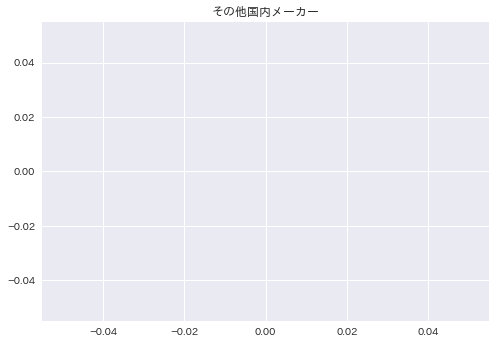

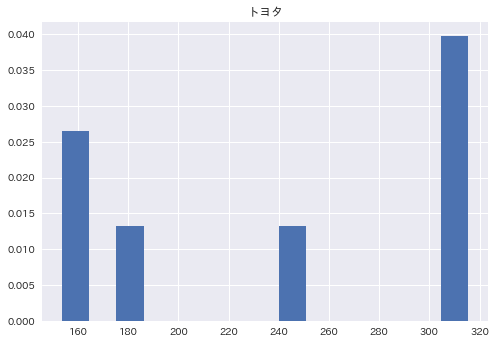

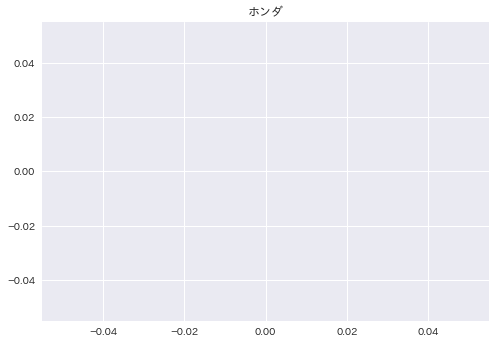

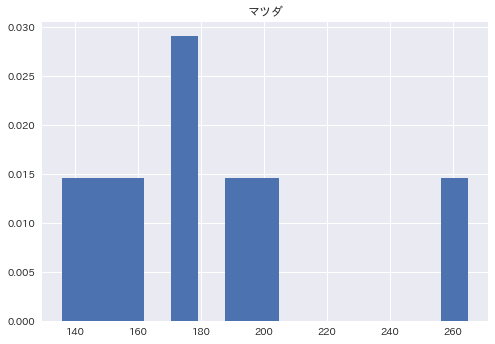

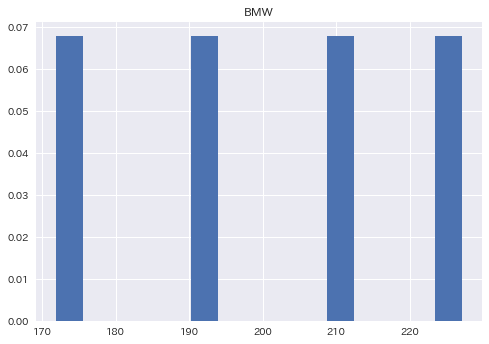

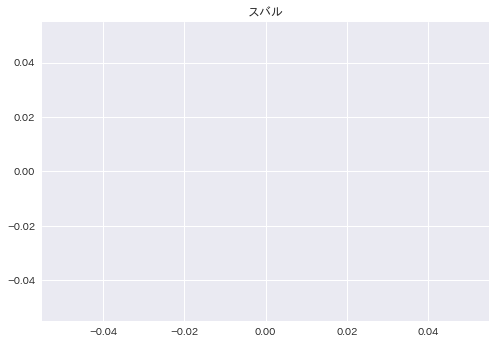

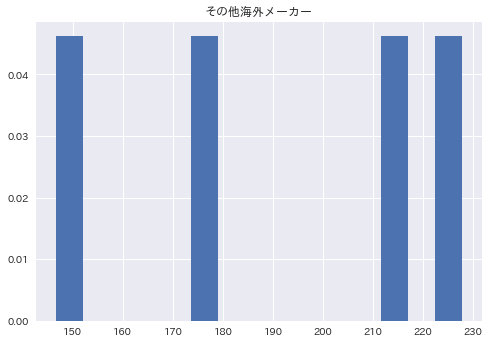

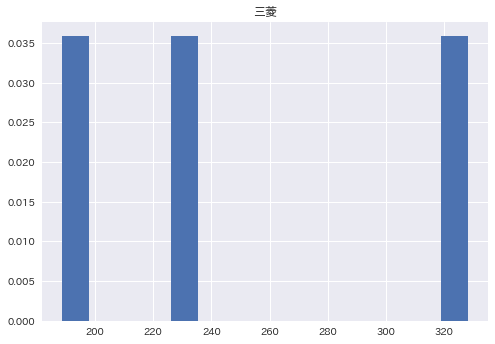

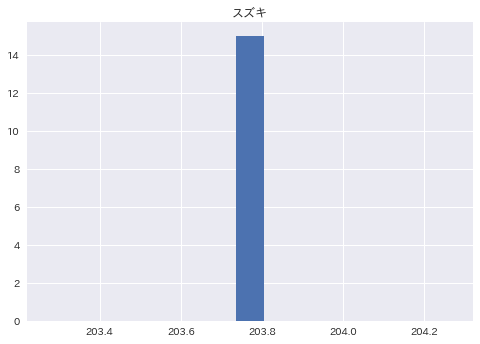

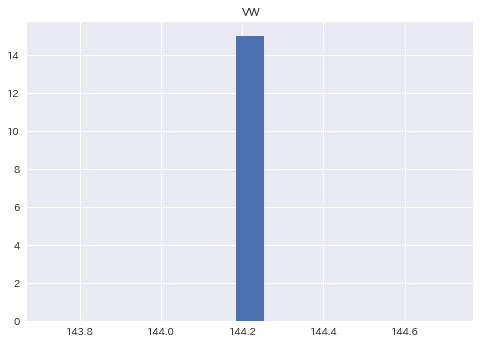

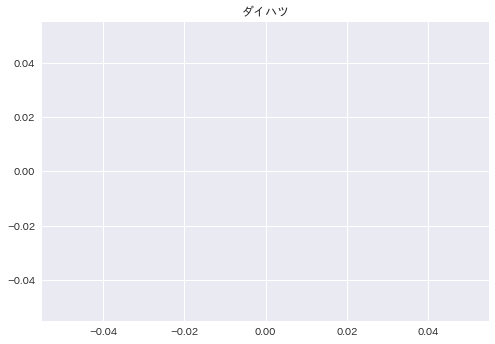

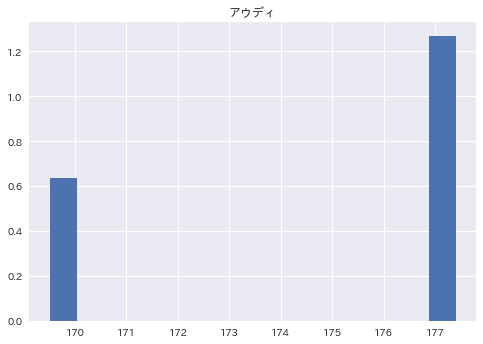

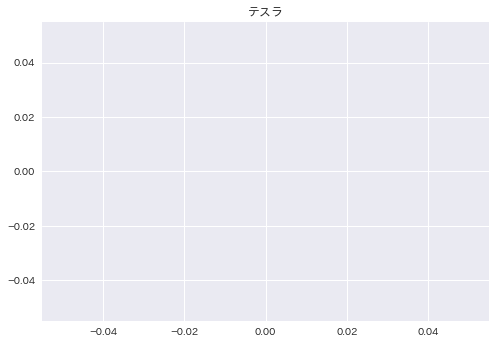

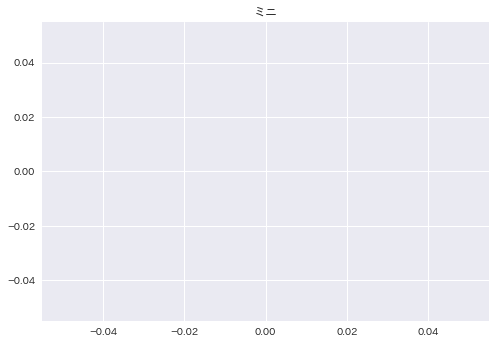

In [546]:
means = {}
car_points = {}
for car_brand in res_df["メーカー"].unique():
    co2_df, m, c = process_missing_data(df2, 'ディーゼル', car_brand)
    means[car_brand] = m
    car_points[car_brand] = c.values

/tmp/ipykernel_9607/3279346693.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(means.keys()), rotation='90')


[Text(0, 0, 'その他国内メーカー'),
 Text(1, 0, '日産'),
 Text(2, 0, 'トヨタ'),
 Text(3, 0, 'ホンダ'),
 Text(4, 0, 'マツダ'),
 Text(5, 0, 'BMW'),
 Text(6, 0, 'スバル'),
 Text(7, 0, 'レクサス'),
 Text(8, 0, 'その他海外メーカー'),
 Text(9, 0, '三菱'),
 Text(10, 0, 'スズキ'),
 Text(11, 0, 'VW'),
 Text(12, 0, 'ダイハツ'),
 Text(13, 0, 'アウディ'),
 Text(14, 0, 'テスラ'),
 Text(15, 0, 'ベンツ'),
 Text(16, 0, 'ミニ')]

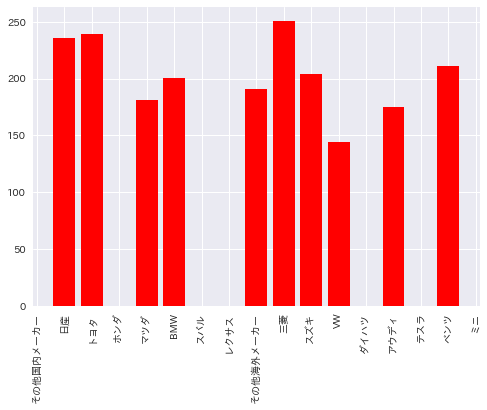

In [547]:
fig, ax=plt.subplots()
ax.bar(list(means.keys()),list(means.values()), facecolor="red")
ax.set_xticklabels(list(means.keys()), rotation='90')
    

(array([2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2.]),
 array([178.6656535 , 185.80534133, 192.94502917, 200.08471701,
        207.22440484, 214.36409268, 221.50378052, 228.64346836,
        235.78315619, 242.92284403, 250.06253187, 257.20221971,
        264.34190754, 271.48159538, 278.62128322, 285.76097106]),
 <BarContainer object of 15 artists>)

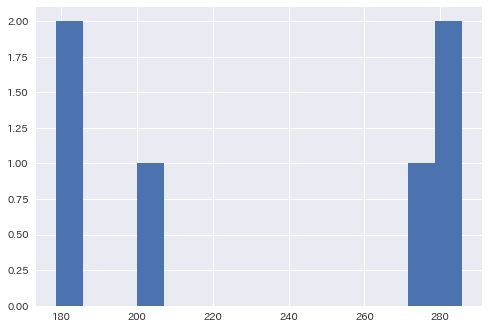

In [548]:
plt.hist(car_points["日産"], 15)

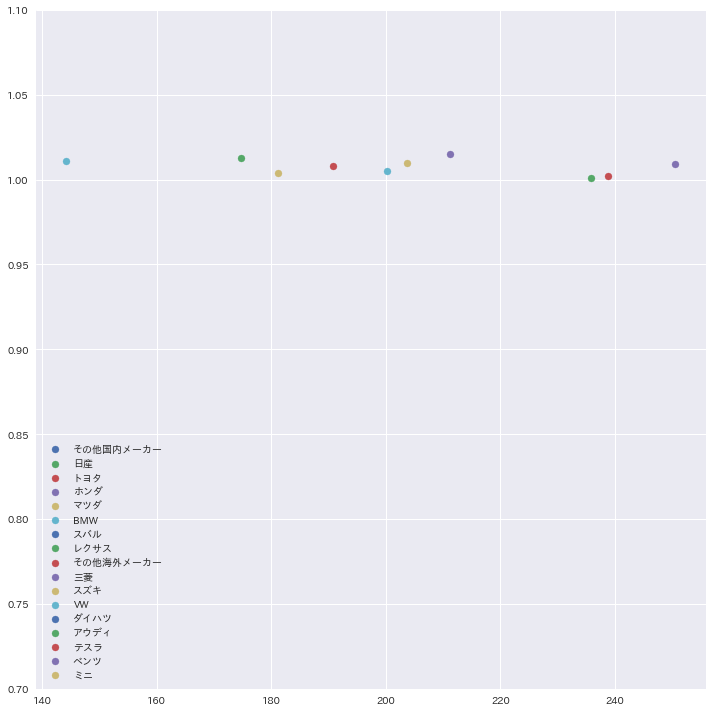

In [549]:
fig, ax=plt.subplots(figsize=(10, 10))
for j, (k, v) in enumerate(means.items()):
    ax.scatter(v,
               1 + j * 0.001, 
              label=k)
ax.legend()
ax.set_ylim([0.7, 1.1])
fig.tight_layout()


In [543]:
def process_missing_data(df, engine_type, body_brand):
    # by car
    df_car = df.query(f'ボディタイプ == "{body_brand}"')
    co2_df = pd.DataFrame(df_car[('CO2排出量(g-CO2/km)_old', engine_type)].copy()).rename(columns={('CO2排出量(g-CO2/km)_old', engine_type): 'co2'})
    co2_df.columns = ['co2']
    co2_df[pd.isna(co2_df["co2"])] = 0.0 
    co2_df = co2_df[~(co2_df["co2"] == 0)] 
    mean, var = np.mean(co2_df["co2"]), np.std(co2_df["co2"])
    fig, ax = plt.subplots()
    
    # counts, bins = np.histogram(co2_df["co2"], 10)

    plt.hist( co2_df["co2"], density=True, bins=20)
    # sns.histplot( co2_df["co2"],stat='probability' )
    ax.set_title(body_brand)
    return co2_df, mean, co2_df["co2"]

/home/barry/projects/bai/bai_backend/.venv/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/barry/projects/bai/bai_backend/.venv/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/tmp/ipykernel_9607/2486243609.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


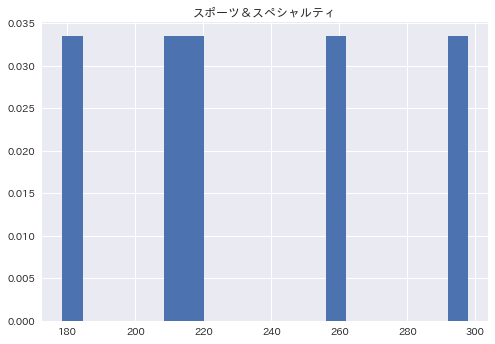

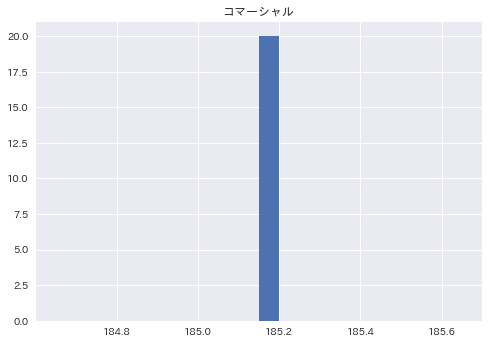

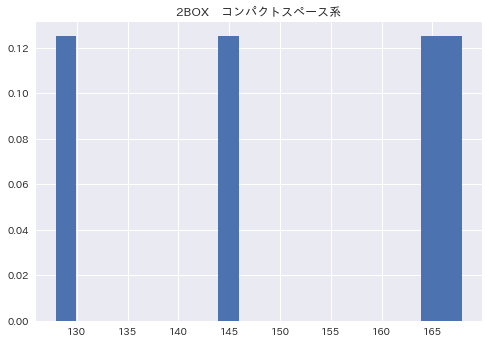

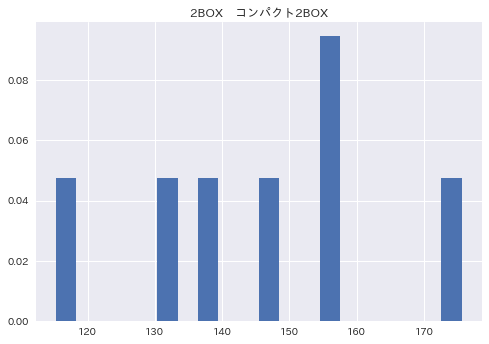

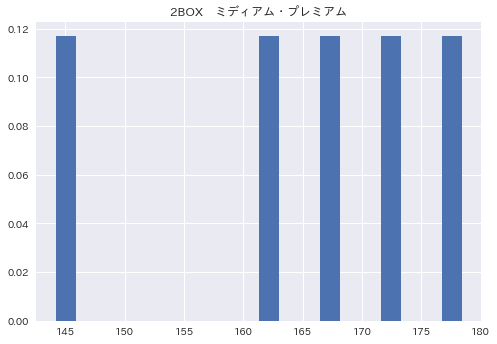

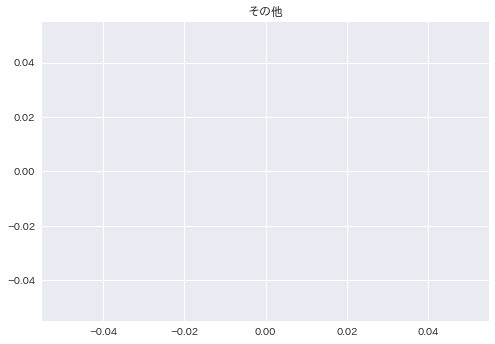

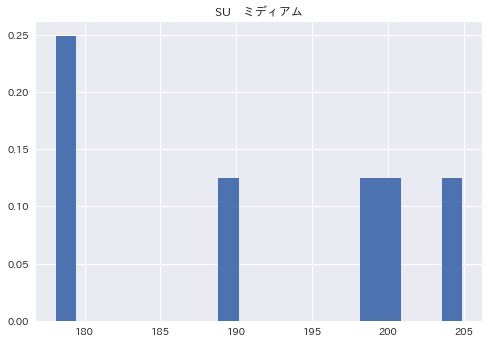

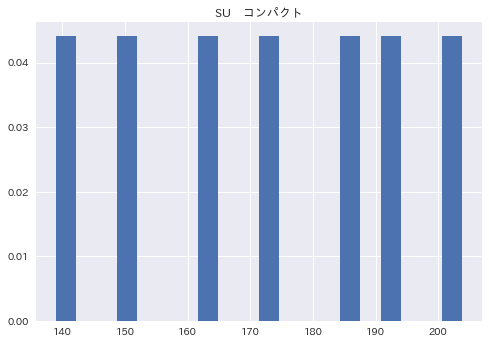

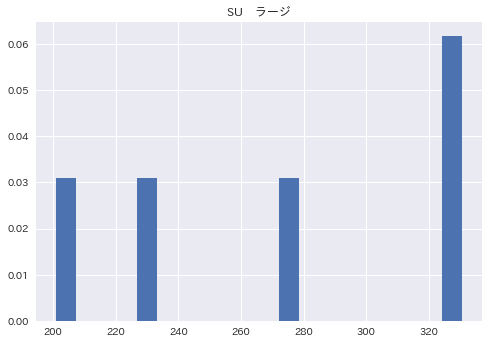

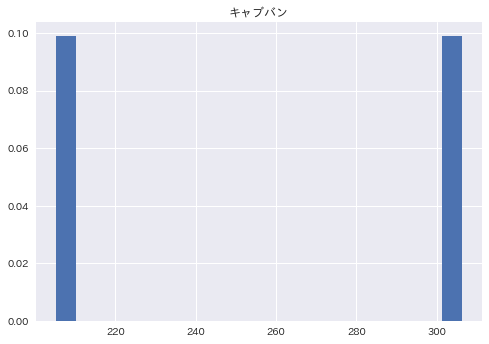

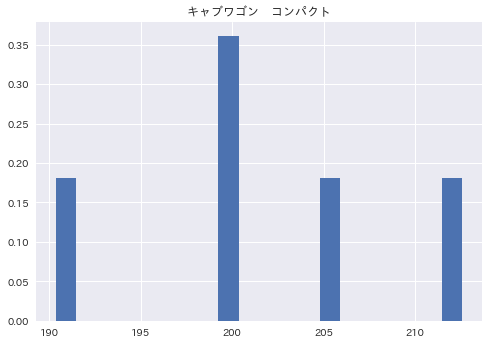

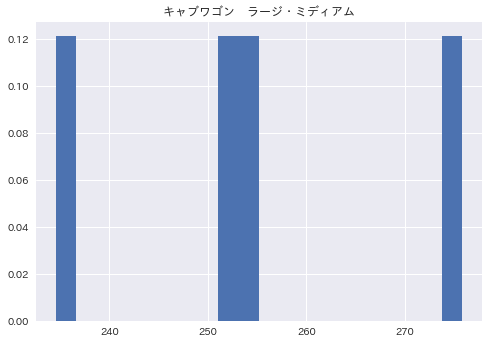

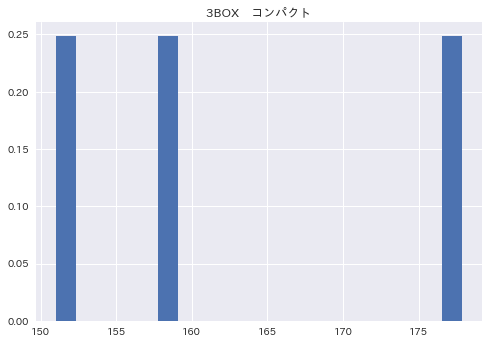

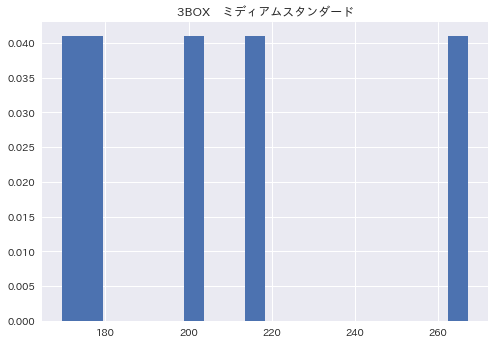

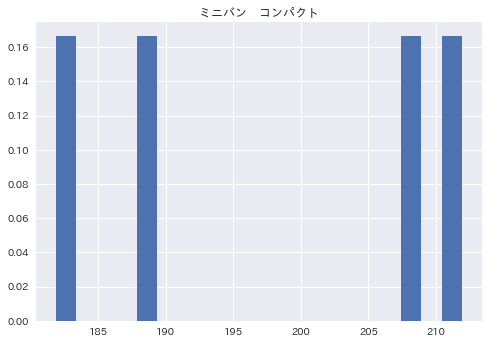

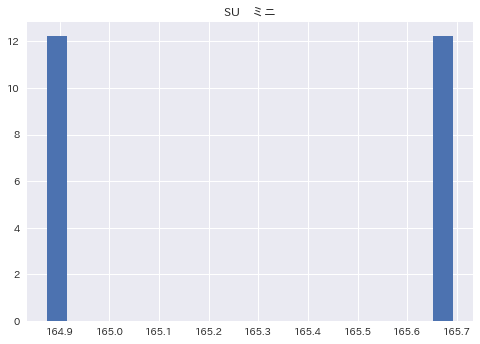

In [544]:
means_body = {}
body_points = {}
for body_brand in res_df["ボディタイプ"].unique():
    co2_df, m, c = process_missing_data(df2, 'ガソリン', body_brand)
    means_body[body_brand] = m
    body_points[car_brand] = c.values

In [510]:
fig, ax=plt.subplots()
ax.bar(list(means_body.keys()),list(means_body.values()), facecolor="red")
ax.set_xticklabels(list(means_body.keys()), rotation='90')

/tmp/ipykernel_9607/745572759.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(means_body.keys()), rotation='90')


[Text(0, 0, 'スポーツ＆スペシャルティ'),
 Text(1, 0, 'コマーシャル'),
 Text(2, 0, 'Sワゴン\u3000コンパクト'),
 Text(3, 0, '軽自動車'),
 Text(4, 0, '2BOX\u3000コンパクトスペース系'),
 Text(5, 0, '2BOX\u3000コンパクト2BOX'),
 Text(6, 0, '2BOX\u3000ミディアム・プレミアム'),
 Text(7, 0, '3BOX\u3000ラージ・プレミアム'),
 Text(8, 0, 'ミニバン\u3000ラージ・ミディアム'),
 Text(9, 0, 'Sワゴン\u3000ミディアムハイ・ラージ'),
 Text(10, 0, 'SU\u3000プレミアム'),
 Text(11, 0, 'その他'),
 Text(12, 0, 'SU\u3000ミディアム'),
 Text(13, 0, 'SU\u3000コンパクト'),
 Text(14, 0, 'SU\u3000ラージ'),
 Text(15, 0, 'キャブバン'),
 Text(16, 0, 'キャブワゴン\u3000コンパクト'),
 Text(17, 0, 'キャブワゴン\u3000ラージ・ミディアム'),
 Text(18, 0, 'キャブトラック'),
 Text(19, 0, '3BOX\u3000ミディアムハイ'),
 Text(20, 0, '3BOX\u3000コンパクト'),
 Text(21, 0, '3BOX\u3000ミディアムスタンダード'),
 Text(22, 0, 'ミニバン\u3000コンパクト'),
 Text(23, 0, 'Sワゴン\u3000ミディアムスタンダード'),
 Text(24, 0, 'SU\u3000ミニ'),
 Text(25, 0, 'ミニバン\u3000ミニミニバン')]

In [550]:
fig, ax=plt.subplots(figsize=(10, 15))
colors = list(map(lambda x: str(x) , list(range(0, 10)))) + ["A", "B", "C", "D", "E", "F"]
import random
# random.choice(["A", "B"])
for j, (k, v) in enumerate(means_body.items()):
    color = "#" + "".join([random.choice(colors) for _ in range(6)])
    ax.scatter(v,
               1 + j * 0.001, 
              label=k,
              color=color)
ax.legend(bbox_to_anchor=(1.5, 1), loc='upper right',)
ax.set_ylim([0.7, 1.1])
fig.tight_layout()


<h1> Interpolation </h1>

<p/> KDE </p>

In [698]:
import torch
from torch import nn
import torch.nn.functional as F

In [725]:
torch.det(torch.eye(4))

tensor(1.)

In [798]:

    
g = GaussianKernel(1, 1)
g(torch.randn((1, )), torch.zeros((1,)))

tensor([0.]) tensor([0.])
Mat det tensor(1.)
tensor(0.3989)


tensor(0.3989)

In [789]:
plt.hist(np.random.normal(size=(10000,)), bins=100, density=True)

(array([0.00118154, 0.        , 0.        , 0.        , 0.00118154,
        0.        , 0.        , 0.        , 0.00118154, 0.00118154,
        0.        , 0.00236308, 0.        , 0.00118154, 0.00236308,
        0.00236308, 0.00118154, 0.00236308, 0.00354463, 0.00472617,
        0.01181542, 0.00708925, 0.01536005, 0.01299696, 0.02481238,
        0.02126776, 0.03190163, 0.04017243, 0.04135397, 0.04726168,
        0.06971098, 0.06971098, 0.07680023, 0.09452336, 0.09334182,
        0.1039757 , 0.13824041, 0.16068971, 0.18786518, 0.17841284,
        0.22449298, 0.24103457, 0.26584695, 0.30838246, 0.31192709,
        0.29893013, 0.32374251, 0.35209952, 0.35800723, 0.36745956,
        0.33792101, 0.40408736, 0.43244437, 0.39699811, 0.40290582,
        0.3686411 , 0.3769119 , 0.37336727, 0.40054274, 0.28829625,
        0.35918877, 0.32965022, 0.33673947, 0.26230232, 0.26584695,
        0.22449298, 0.24103457, 0.19613597, 0.16777896, 0.16187125,
        0.13824041, 0.13469579, 0.09452336, 0.09

In [794]:
6.28 ** (-0.5)

0.39904344223381105

In [1135]:
class GaussianKernel(nn.Module):
    def __init__(self, dim, sigma):
        super().__init__()
        self.sigma = sigma
        self.dim = dim
        self.cov = torch.eye(dim).to(dtype=torch.float32) * self.sigma
        mat_det = torch.det(self.cov)
        
    def forward(self, x, mu):
        # x = torch.zeros_like(x)
        # mat_det = torch.det(self.cov)
        # d = ((2 * torch.pi) ** self.dim) * mat_det
        # d = torch.rsqrt(d)
#         num = torch.exp(-0.5 * ( (x - mu).T @ torch.linalg.inv(self.cov) @ (x-mu)  ))
#         return num # *  d
        x = x.unsqueeze(dim=1)
        return torch.exp(-(0.5 / self.sigma ) * ( (x - mu)* (x-mu)  ) ).sum(dim=2)

class KDENet(nn.Module):
    
    def __init__(self, num_car=17, num_box=25, num_eng=6, car_types=None):
        super().__init__()
        # self.sigma = sigma
        # self.car_types = car_types
        # self.x = nn.Parameter(torch.normal(50, 20.0, size=(len(car_types), )), )
        # self.kernel = GaussianKernel(len(car_types), sigma)
        # self.car_net = nn.Linear(num_car, 10)
        # self.box_net = nn.Linear(num_box, 5)
        # self.engine_net = nn.Linear(num_eng, 5)
        
        self.net = nn.Linear(num_car + num_box + num_eng, 32)
        self.net1 = nn.Linear(32, 10)
        self.net2 = nn.Linear(32, 5)
        
        self.mu = nn.Linear(32, num_car + num_box + num_eng)
        
        self.kernel = GaussianKernel(num_car, sigma=1.0)
        self.leaky_rul = nn.LeakyReLU(0.2)
        
    def forward(self, cars, boxes, engines, mu):
        x = torch.concat([cars, boxes, engines], dim=1)
        x = nn.ReLU()(self.net(x))
        feat = nn.ReLU()(self.net1(x))
        y = nn.ReLU()(self.net2(x))
        x = self.leaky_rul(self.kernel(feat, mu))
        out = x * y
        
        out = out.sum(dim=1)
        return out, feat
        


In [1136]:
def knn(feat, mu):
    with torch.no_grad():
        x = torch.square(feat.unsqueeze(1) - mu)
        x = torch.sum(x, dim=-1)
        args = torch.argmin(x, dim=1)
        mus = []

        for  i in range(mu.shape[1]):
            idx = torch.argwhere(args == i ).squeeze()
            if len(idx):
                _mu = torch.mean(feat[idx], dim=0)
            else:
                _mu = mu[0][i]
            mus.append(_mu)
        mus = torch.stack(mus)
        mus = torch.broadcast_to(mus, (mu.shape[0], mu.shape[1],  mus.shape[1],))
        return mus
    


In [1177]:
net = KDENet()
loss_fn = nn.MSELoss()
losses = []
optimizer = torch.optim.SGD(net.parameters(), lr=0.0001)
for i in range(100000):
    optimizer.zero_grad()
    out, feat = net(cars, boxes, engines, mu)
    l = loss_fn(out, _targets)
    losses.append(l.item())
    l.backward()
    optimizer.step()
    mu = knn(feat, mu)
    # print(f"Epoch {i}, loss {l.item()}")
    

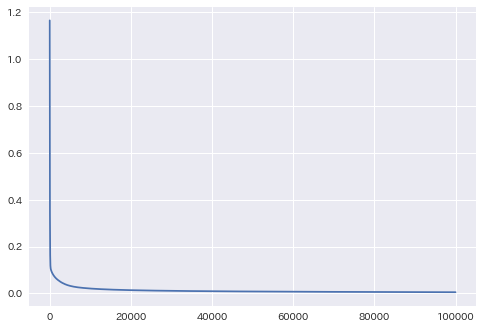

In [1178]:
plt.plot(losses)

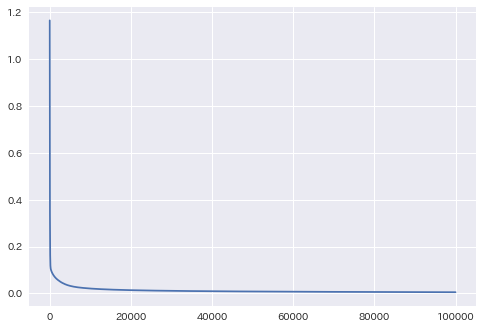

In [1246]:
plt.plot(losses)
plt.savefig('./data/MASTER/po.png')

In [1179]:
losses[-10:]

[0.004988105036318302,
 0.0049880677834153175,
 0.004988028202205896,
 0.004987990949302912,
 0.004987951368093491,
 0.004987913183867931,
 0.004987874999642372,
 0.004987835884094238,
 0.004987798165529966,
 0.004987759981304407]

In [1184]:
out

tensor([0.4633, 0.5081, 0.5853, 0.6311, 0.6536, 0.6332, 0.5792, 0.5890, 0.6372,
        0.4781, 0.4094, 0.4779, 0.4644, 0.5289, 0.6892, 0.6362, 0.6469, 0.6034,
        0.7895, 0.6006, 0.6039, 0.4775, 0.5291, 0.5613, 0.4985, 0.4704, 0.4817,
        0.4807, 0.5610, 0.3287, 0.5616, 0.5372, 0.2660, 0.6221, 0.3967, 0.4617,
        0.3613, 0.4433, 0.4645, 0.3499, 0.5656, 0.5922, 0.6634, 0.5338, 0.4683,
        0.5020, 0.4600, 0.5287, 0.5850, 0.5685, 0.6471, 0.7048, 0.4131, 0.5109,
        0.4132, 0.3550, 0.4546, 0.3256, 0.2980, 0.3315, 0.4134, 0.2169, 0.4398,
        0.5578, 0.4756, 0.2816, 0.4538, 0.3532, 0.4170, 0.5920, 0.3956, 0.6832,
        0.7513, 0.7706, 0.5009, 0.7393, 0.4740, 0.2726, 0.5569, 0.4009, 0.5055,
        0.7290, 0.7510, 0.4711, 0.4705, 0.2420, 0.6066, 0.3019, 0.6851, 0.6021,
        0.7856, 0.4951, 0.3986, 0.7904, 0.7652, 0.5151, 0.5165, 0.5636, 0.5881,
        0.4667, 0.6646, 0.6361, 0.4339, 0.3035, 0.6691, 0.4130, 0.4453, 0.4889,
        0.3412, 0.8300, 0.6780, 0.5291, 

In [1183]:
_targets

tensor([0.4910, 0.4910, 0.6489, 0.6489, 0.6489, 0.6023, 0.6023, 0.5466, 0.5466,
        0.4121, 0.4121, 0.4121, 0.4785, 0.4975, 0.6507, 0.6507, 0.6528, 0.4190,
        0.7967, 0.6377, 0.6143, 0.4647, 0.4904, 0.5068, 0.4843, 0.4843, 0.5068,
        0.5068, 0.4441, 0.2985, 0.5822, 0.5822, 0.3059, 0.5700, 0.5024, 0.3921,
        0.2813, 0.4798, 0.5018, 0.4268, 0.5082, 0.6143, 0.6143, 0.4954, 0.4954,
        0.5401, 0.4492, 0.5082, 0.6143, 0.5624, 0.6103, 0.6171, 0.3490, 0.5414,
        0.3294, 0.3375, 0.4734, 0.3014, 0.3274, 0.3846, 0.3905, 0.2796, 0.4159,
        0.4315, 0.4428, 0.2355, 0.4848, 0.3009, 0.2299, 0.7346, 0.3333, 0.7121,
        0.7542, 0.7121, 0.4967, 0.7121, 0.4679, 0.2632, 0.5854, 0.3190, 0.4711,
        0.9442, 0.9014, 0.4732, 0.4394, 0.2355, 0.4930, 0.2524, 0.7076, 0.8751,
        0.8751, 0.5703, 0.4252, 0.7281, 0.8751, 0.5638, 0.5070, 0.5290, 0.5290,
        0.5070, 0.6136, 0.5380, 0.4446, 0.2847, 0.7732, 0.3776, 0.3057, 0.5097,
        0.5097, 0.7180, 0.7180, 0.5697, 

In [1268]:
def fill_missing_with_kernel(net, mu, df):
    num_car, num_box, num_eng = 17, 25, 6
    # TODO
    target_max = 350.
    df = df.copy(deep=True)
    
 
    
    car_types = np.unique([x[0] for x in df.index.values[:,]]).tolist()
    box_types = np.unique([x[1] for x in df.index.values[:,]]).tolist()
    engines = np.unique([x[1] for x in df.columns[:]]).tolist()
    for col in df.columns:
        if 'CO2排出量(g-CO2/km)_old' in col[0]:
            df.loc[:, ('CO2排出量(g-CO2/km)_new', col[1])] = pd.NA
    for i in range(len(df)):
        car, box = df.index[i]
        car_id, box_id = car_types.index(car), box_types.index(box)
        cars, boxes= F.one_hot(torch.tensor(car_id), num_car).to(torch.float32).unsqueeze(0),  F.one_hot(torch.tensor(box_id), num_box).to(torch.float32).unsqueeze(0)
        k = 0
        
        for col in df.columns:
            if 'CO2排出量(g-CO2/km)_old' in col[0]:
                index = df.index[i]
                df.loc[index, ('CO2排出量(g-CO2/km)_new', col[1])] = df.iloc[i][ ('CO2排出量(g-CO2/km)_old' , col[1])]
            
            
    for i in range(len(df)):
        car, box = df.index[i]
        car_id, box_id = car_types.index(car), box_types.index(box)
        cars, boxes= F.one_hot(torch.tensor(car_id), num_car).to(torch.float32).unsqueeze(0),  F.one_hot(torch.tensor(box_id), num_box).to(torch.float32).unsqueeze(0)
        k = 0
        for co2, et in [ 
            ('CO2排出量(g-CO2/km)_new',     'その他ガスなど'),
            ('CO2排出量(g-CO2/km)_new',        'ガソリン'),
            ('CO2排出量(g-CO2/km)_new',       'ディーゼル'),
            ('CO2排出量(g-CO2/km)_new',      'ハイブリッド'),
            ('CO2排出量(g-CO2/km)_new', 'プラグインハイブリッド'),
            ('CO2排出量(g-CO2/km)_new',     '不明/該当なし'),]:
            if not pd.isna(df.iloc[i][ (co2, et)]) and  df.iloc[i][ (co2, et)] == 0.0:
                engines = F.one_hot(torch.tensor(k), num_eng).to(torch.float32).unsqueeze(0)
                with torch.no_grad():
                    res, _ = net(cars, boxes, engines, mu[0])
                    res = (res[0] * target_max).item()
                    index = df.index[i]
                    df.loc[index, (co2, et)] = res
                
            k += 1
    return df

df3 = fill_missing_with_kernel(net, mu, df2)
    
    

In [1271]:
df3.reset_index().to_excel("./data/MASTER/最終的に欲しいバックデータ形式_230228処理結果-v1.xlsx")

In [1232]:
from sklearn.manifold import TSNE

In [1241]:
def visualize_embedding(df):
    num_car, num_box, num_eng = 17, 25, 6
    target_max = 350.
    df = df.copy(deep=True)
    
    car_types = np.unique([x[0] for x in df.index.values[:,]]).tolist()
    box_types = np.unique([x[1] for x in df.index.values[:,]]).tolist()
    engines = np.unique([x[1] for x in df.columns[:]]).tolist()
    cols = [ ('CO2排出量(g-CO2/km)_old', et) for et in engines]

    for ct in car_types:
        _df = df.query(f'メーカー == "{ct}"')[cols].copy()
        return _df
        
    
#     for i in range(len(df)):
#         car, box = df.index[i]
#         car_id, box_id = car_types.index(car), box_types.index(box)
#         cars, boxes= F.one_hot(torch.tensor(car_id), num_car).to(torch.float32).unsqueeze(0),  F.one_hot(torch.tensor(box_id), num_box).to(torch.float32).unsqueeze(0)
        
#         k = 0
        
#         for co2, et in [ 
#             ('CO2排出量(g-CO2/km)_old',     'その他ガスなど'),
#             ('CO2排出量(g-CO2/km)_old',        'ガソリン'),
#             ('CO2排出量(g-CO2/km)_old',       'ディーゼル'),
#             ('CO2排出量(g-CO2/km)_old',      'ハイブリッド'),
#             ('CO2排出量(g-CO2/km)_old', 'プラグインハイブリッド'),
#             ('CO2排出量(g-CO2/km)_old',     '不明/該当なし'),]:
#             if not pd.isna(df.iloc[i][ (co2, et)]) and  df.iloc[i][ (co2, et)] == 0.0:
#                 engines = F.one_hot(torch.tensor(k), num_eng).to(torch.float32).unsqueeze(0)
#                 with torch.no_grad():
#                     res, _ = net(cars, boxes, engines, mu[0])
#                     res = (res[0] * target_max).item()
#                     df.iloc[i][ (co2, et)] = res
                
                
                
    return df

visualize_embedding(df3)

CO2排出量(g-CO2/km)_old                          \
                                   その他ガスなど        ガソリン       ディーゼル   
メーカー ボディタイプ                                                          
BMW  2BOX　ミディアム・プレミアム                  NaN  171.854798  171.854798   
     3BOX　ラージ・プレミアム                    NaN  227.100401  227.100401   
     SU　プレミアム                          NaN  210.789225  210.789225   
     ミニバン　ラージ・ミディアム                    NaN  195.857468  227.927567   
     Sワゴン　ミディアムハイ・ラージ                  NaN  191.296557  191.296557   
     スポーツ＆スペシャルティ                      NaN  225.894424  234.125671   
     その他                               NaN         NaN         NaN   

                                                                     
                           ハイブリッド プラグインハイブリッド     不明/該当なし 燃料電池   電気  
メーカー ボディタイプ                                                          
BMW  2BOX　ミディアム・プレミアム         NaN  135.159424         NaN  NaN  0.0  
     3BOX　ラージ・プレミアム    171.382828  109.656403  227.100401  NaN  0.0  
     SU　プレミアム          159.966843  135.479553         NaN  NaN  0.0  
     ミニバン　ラージ・ミディアム           NaN         NaN         NaN  NaN  NaN  
     Sワゴン　ミディアムハイ・ラージ         NaN         NaN         NaN  NaN  NaN  
     スポーツ＆スペシャルティ             NaN  147.387695  206.530594  NaN  NaN  
     その他                      NaN         NaN  275.607788  NaN  NaN

In [ ]:
X_embedded = TSNE(n_components=2, learning_rate='auto',
.init='random', perplexity=3).fit_transform(X)

In [1231]:
df3['CO2排出量(g-CO2/km)_old']

電気  プラグインハイブリッド      ハイブリッド  燃料電池        ガソリン  \
メーカー      ボディタイプ                                                             
トヨタ       2BOX　コンパクト2BOX    0.0          NaN   97.864567   NaN  136.658793   
          2BOX　コンパクトスペース系   NaN          NaN         NaN   NaN  145.554638   
          2BOX　ミディアム・プレミアム  NaN          NaN   43.289249   NaN  155.351227   
          3BOX　コンパクト        NaN          NaN   82.432407   NaN  151.030970   
          3BOX　ミディアムスタンダード  NaN    80.464738  105.307172   NaN  169.665468   
...                         ...          ...         ...   ...         ...   
その他海外メーカー キャブワゴン　ラージ・ミディアム  NaN          NaN         NaN   NaN  218.478012   
          キャブバン             NaN          NaN         NaN   NaN  235.873367   
          コマーシャル            NaN          NaN         NaN   NaN  170.772385   
          軽自動車              NaN          NaN         NaN   NaN  135.543564   
          その他               NaN          NaN         NaN   NaN  231.951843   

                                 ディーゼル     その他ガスなど     不明/該当なし  
メーカー      ボディタイプ                                                
トヨタ       2BOX　コンパクト2BOX    142.271225         NaN         NaN  
          2BOX　コンパクトスペース系          NaN         NaN         NaN  
          2BOX　ミディアム・プレミアム         NaN         NaN         NaN  
          3BOX　コンパクト        154.992041         NaN  232.006729  
          3BOX　ミディアムスタンダード  207.058517  162.586243  217.187363  
...                                ...         ...         ...  
その他海外メーカー キャブワゴン　ラージ・ミディアム  199.117722         NaN  217.589966  
          キャブバン             280.830750         NaN         NaN  
          コマーシャル            184.286819         NaN         NaN  
          軽自動車                     NaN         NaN         NaN  
          その他               251.033371         NaN  261.923126  

[225 rows x 8 columns]

In [1196]:
df2.columns

MultiIndex([(            '走行距離(km)',          '電気'),
            (            '走行距離(km)', 'プラグインハイブリッド'),
            (            '走行距離(km)',      'ハイブリッド'),
            (            '走行距離(km)',        '燃料電池'),
            (            '走行距離(km)',        'ガソリン'),
            (            '走行距離(km)',       'ディーゼル'),
            (            '走行距離(km)',     'その他ガスなど'),
            (            '走行距離(km)',     '不明/該当なし'),
            (    'CO2排出量(g-CO2/km)',          '電気'),
            (    'CO2排出量(g-CO2/km)', 'プラグインハイブリッド'),
            (    'CO2排出量(g-CO2/km)',      'ハイブリッド'),
            (    'CO2排出量(g-CO2/km)',        '燃料電池'),
            (    'CO2排出量(g-CO2/km)',        'ガソリン'),
            (    'CO2排出量(g-CO2/km)',       'ディーゼル'),
            (    'CO2排出量(g-CO2/km)',     'その他ガスなど'),
            (    'CO2排出量(g-CO2/km)',     '不明/該当なし'),
            (       '合計 /  SUM(台数)',          '電気'),
            (       '合計 /  SUM(台数)', 'プラグインハイブリッド'),
            (       '合計 /  SUM(台数)',      'ハイブ

In [1194]:
df2#.keys('燃費_平均値(平均)')

走行距離(km)                                 \
                                    電気  プラグインハイブリッド       ハイブリッド 燃料電池   
メーカー      ボディタイプ                                                        
トヨタ       2BOX　コンパクト2BOX    6236.20247          NaN  6189.937547  NaN   
          2BOX　コンパクトスペース系          NaN          NaN          NaN  NaN   
          2BOX　ミディアム・プレミアム         NaN          NaN  6236.202476  NaN   
          3BOX　コンパクト               NaN          NaN  7850.086744  NaN   
          3BOX　ミディアムスタンダード         NaN  7850.086744  7815.867342  NaN   
...                                ...          ...          ...  ...   
その他海外メーカー キャブワゴン　ラージ・ミディアム         NaN          NaN          NaN  NaN   
          キャブバン                    NaN          NaN          NaN  NaN   
          コマーシャル                   NaN          NaN          NaN  NaN   
          軽自動車                     NaN          NaN          NaN  NaN   
          その他                      NaN          NaN          NaN  NaN   

                                                                     \
                                    ガソリン         ディーゼル      その他ガスなど   
メーカー      ボディタイプ                                                      
トヨタ       2BOX　コンパクト2BOX     4975.735561   4961.263711          NaN   
          2BOX　コンパクトスペース系    5521.012027           NaN          NaN   
          2BOX　ミディアム・プレミアム   4961.263711           NaN          NaN   
          3BOX　コンパクト         5654.030476   5654.030476          NaN   
          3BOX　ミディアムスタンダード   5654.030476   5654.030476  5654.030476   
...                                  ...           ...          ...   
その他海外メーカー キャブワゴン　ラージ・ミディアム   5651.626636   5651.626636          NaN   
          キャブバン              5651.626636   5651.626636          NaN   
          コマーシャル            10075.502331  10075.502331          NaN   
          軽自動車                  0.000000           NaN          NaN   
          その他                7894.932862   7894.932863          NaN   

                                        CO2排出量(g-CO2/km)              ...  \
                                不明/該当なし               電気 プラグインハイブリッド  ...   
メーカー      ボディタイプ                                                      ...   
トヨタ       2BOX　コンパクト2BOX            NaN              0.0         NaN  ...   
          2BOX　コンパクトスペース系           NaN              NaN         NaN  ...   
          2BOX　ミディアム・プレミアム          NaN              NaN         NaN  ...   
          3BOX　コンパクト        5654.030471              NaN         NaN  ...   
          3BOX　ミディアムスタンダード  5654.030476              NaN   80.464738  ...   
...                                 ...              ...         ...  ...   
その他海外メーカー キャブワゴン　ラージ・ミディアム  5651.626636              NaN         NaN  ...   
          キャブバン                     NaN              NaN         NaN  ...   
          コマーシャル                    NaN              NaN         NaN  ...   
          軽自動車                      NaN              NaN         NaN  ...   
          その他               7894.932863              NaN         NaN  ...   

                           合計 /  SUM(台数)           CO2排出量(g-CO2/km)_old  \
                                 その他ガスなど   不明/該当なし                   電気   
メーカー      ボディタイプ                                                          
トヨタ       2BOX　コンパクト2BOX             NaN       NaN                  0.0   
          2BOX　コンパクトスペース系            NaN       NaN                  NaN   
          2BOX　ミディアム・プレミアム           NaN       NaN                  NaN   
          3BOX　コンパクト                 NaN       1.0                  NaN   
          3BOX　ミディアムスタンダード          88.0      50.0                  NaN   
...                                  ...       ...                  ...   
その他海外メーカー キャブワゴン　ラージ・ミディアム           NaN    6166.0                  NaN   
          キャブバン                      NaN       NaN                  NaN   
          コマーシャル                     NaN       NaN                  NaN   
          軽自動車                   

In [1124]:
def prepare_data(inputs, targets, means):
    num_car, num_box, num_eng = 17, 25, 6
    inputs = torch.tensor(inputs)
    cars, boxes, engines = torch.tensor_split(inputs,3, dim=1)
    cars = torch.squeeze(cars)
    boxes= torch.squeeze(boxes)
    engines = torch.squeeze(engines)
    cars = F.one_hot(cars, num_car).to(torch.float32)
    boxes = F.one_hot(boxes, num_box).to(torch.float32)
    engines = F.one_hot(engines, num_eng).to(torch.float32)
    targets = torch.from_numpy(targets).to(torch.float32)
    means = torch.from_numpy(means).to(torch.float32)
    target_max = 350.
    return cars, boxes, engines, targets / target_max




In [1125]:
cars, boxes, engines, _targets = prepare_data(inputs, targets, means)  
mu = torch.randn( (5, 10,), )
mu =  torch.broadcast_to(mu, (cars.shape[0], 5, 10))

In [1126]:
mu[0]

tensor([[ 0.7285, -0.4535,  0.9778,  0.7290,  0.0557, -0.4789, -0.0768, -1.7759,
         -0.0270, -0.4974],
        [ 1.2612, -0.6458, -0.7105,  0.2711, -0.4141,  1.3208,  0.1991,  1.0890,
         -1.6288,  0.7887],
        [-0.1150,  0.0374, -1.8515, -0.4821, -0.2138, -0.3428,  1.2437,  1.3944,
         -0.3562,  0.0284],
        [-0.3834, -1.8730,  0.0909, -0.8021,  0.4825, -1.0516,  0.6638,  0.0076,
          0.7315, -1.4008],
        [-0.1457, -0.4854, -0.2305,  0.7827, -0.5691,  0.2497,  0.5189,  1.2155,
         -0.5135, -0.2777]])

In [998]:
def train(dfs, epsilon=1e-9):
    # net = KDENet(car_types=['BMW', 'VW', 'その他国内メーカー', 'その他海外メーカー', 'アウディ', 'スズキ', 'スバル', 'ダイハツ', 
    #                     'テスラ', 'トヨタ', 'ベンツ', 'ホンダ', 'マツダ', 'ミニ', 'レクサス', '三菱', '日産'])  
    # optmizer = torch.optim.SGD(net.parameters(), lr=0.01,)
    targets = []
    masks = []
    inputs = []
    means = []
    
    for i, (k, df) in enumerate(dfs.items()):
        target = df["CO2排出量(g-CO2/km)_old"]  * df["mask"]
        target = target.values
        indices = np.argwhere(target > 0.0)
        target_mean = []
        for id1, id2 in indices:
            inputs.append((i, id1, id2))
            targets.append(target[id1, id2])
            target_mean.append(target[id1, id2])
        masks.append(df["mask"].sum() + epsilon)
        m = np.mean(target_mean)
        for _ in range(len(target_mean)):
            means.append(m)
    targets = np.stack(targets)
    inputs = np.stack(inputs)
    means = np.array(means)
    
    
    return inputs, targets, means



In [999]:
inputs, targets, means = train(r)

/home/barry/projects/bai/bai_backend/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/barry/projects/bai/bai_backend/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [1206]:
r['BMW'].columns

MultiIndex([(                'メーカー',            ''),
            (              'ボディタイプ',            ''),
            ('CO2排出量(g-CO2/km)_old',     'その他ガスなど'),
            ('CO2排出量(g-CO2/km)_old',        'ガソリン'),
            ('CO2排出量(g-CO2/km)_old',       'ディーゼル'),
            ('CO2排出量(g-CO2/km)_old',      'ハイブリッド'),
            ('CO2排出量(g-CO2/km)_old', 'プラグインハイブリッド'),
            ('CO2排出量(g-CO2/km)_old',     '不明/該当なし'),
            (                'mask',     'その他ガスなど'),
            (                'mask',        'ガソリン'),
            (                'mask',       'ディーゼル'),
            (                'mask',      'ハイブリッド'),
            (                'mask', 'プラグインハイブリッド'),
            (                'mask',     '不明/該当なし')],
           )

In [1253]:
555-6

549

In [1254]:
214 / 549

0.38979963570127507

In [825]:
inputs.shape

(214, 3)

In [826]:
targets.shape

(214,)

In [827]:
means.shape

(214,)

In [697]:
def interpolate1(df, ):
    car_types = np.unique([x[0] for x in df.index.values[:,]])
    box_types = np.unique([x[1] for x in df.index.values[:,]])
    engines = np.unique([x[1] for x in df.columns[:]])
    cols = [ ('CO2排出量(g-CO2/km)_old', et) for et in engines]
    res = {}
    net = KDENet(car_types=car_types.tolist())
    
    for ct in car_types:
        
        _df = df.query(f'メーカー == "{ct}"')[cols].copy()
        for col in engines:
            _df.loc[:, ("mask", col)] = 0.
        _df[pd.isna(_df)] = 0.0
        _df = _df.drop(columns=[ ('CO2排出量(g-CO2/km)_old', '燃料電池'),
                         ('CO2排出量(g-CO2/km)_old', '電気'),
                          ('mask',  '燃料電池'),
                         ('mask', '電気'),
                        ])
        for bt in box_types:
            if (ct, bt) not in _df.index:
                _df.loc[(ct, bt), :] = 0.
        _df = _df.reset_index()
        _df = _df.sort_values(["メーカー", "ボディタイプ"]).reset_index(drop=True)
        
        for et in _df["mask"].columns:
            val = _df[('CO2排出量(g-CO2/km)_old', et)] > 0.0
            val = val.values.astype(float)
            _df.loc[:, ("mask", et)] = val
        res[ct] = _df
        
    # res = pd.concat(res)
    return res
 
    

r = interpolate1(df2)

['BMW', 'VW', 'その他国内メーカー', 'その他海外メーカー', 'アウディ', 'スズキ', 'スバル', 'ダイハツ', 'テスラ', 'トヨタ', 'ベンツ', 'ホンダ', 'マツダ', 'ミニ', 'レクサス', '三菱', '日産']
Parameter containing:
tensor([28.3768, 63.8865, 66.5821, 57.5259, 26.8633, 41.5717, 59.0621, 22.5682,
        62.7839, 59.4723, 50.0149, 85.3662, 45.9351, 58.7179, 65.9675, 42.5242,
        71.3043], requires_grad=True)


In [677]:
net = KDENet(car_types=['BMW' 'VW' 'その他国内メーカー' 'その他海外メーカー' 'アウディ' 'スズキ' 'スバル' 'ダイハツ' 'テスラ' 'トヨタ'
 'ベンツ' 'ホンダ' 'マツダ' 'ミニ' 'レクサス' '三菱' '日産'])

In [708]:
r['BMW']

メーカー            ボディタイプ CO2排出量(g-CO2/km)_old                                 \
                                       その他ガスなど        ガソリン       ディーゼル ハイブリッド   
0   BMW    2BOX　コンパクト2BOX                  0.0    0.000000    0.000000    0.0   
1   BMW   2BOX　コンパクトスペース系                  0.0    0.000000    0.000000    0.0   
2   BMW  2BOX　ミディアム・プレミアム                  0.0  171.854798  171.854798    0.0   
3   BMW        3BOX　コンパクト                  0.0    0.000000    0.000000    0.0   
4   BMW  3BOX　ミディアムスタンダード                  0.0    0.000000    0.000000    0.0   
5   BMW      3BOX　ミディアムハイ                  0.0    0.000000    0.000000    0.0   
6   BMW    3BOX　ラージ・プレミアム                  0.0  227.100401  227.100401    0.0   
7   BMW          SU　コンパクト                  0.0    0.000000    0.000000    0.0   
8   BMW          SU　プレミアム                  0.0  210.789225  210.789225    0.0   
9   BMW          SU　ミディアム                  0.0    0.000000    0.000000    0.0   
10  BMW             SU　ミニ                  0.0    0.000000    0.000000    0.0   
11  BMW            SU　ラージ                  0.0    0.000000    0.000000    0.0   
12  BMW        Sワゴン　コンパクト                  0.0    0.000000    0.000000    0.0   
13  BMW  Sワゴン　ミディアムスタンダード                  0.0    0.000000    0.000000    0.0   
14  BMW  Sワゴン　ミディアムハイ・ラージ                  0.0  191.296557  191.296557    0.0   
15  BMW               その他                  0.0    0.000000    0.000000    0.0   
16  BMW             キャブバン                  0.0    0.000000    0.000000    0.0   
17  BMW      キャブワゴン　コンパクト                  0.0    0.000000    0.000000    0.0   
18  BMW  キャブワゴン　ラージ・ミディアム                  0.0    0.000000    0.000000    0.0   
19  BMW            コマーシャル                  0.0    0.000000    0.000000    0.0   
20  BMW      スポーツ＆スペシャルティ                  0.0    0.000000    0.000000    0.0   
21  BMW        ミニバン　コンパクト                  0.0    0.000000    0.000000    0.0   
22  BMW       ミニバン　ミニミニバン                  0.0    0.000000    0.000000    0.0   
23  BMW    ミニバン　ラージ・ミディアム                  0.0    0.000000    0.000000    0.0   
24  BMW              軽自動車                  0.0    0.000000    0.000000    0.0   

                              mask                                        
   プラグインハイブリッド     不明/該当なし その他ガスなど ガソリン ディーゼル ハイブリッド プラグインハイブリッド 不明/該当なし  
0          0.0    0.000000     0.0  0.0   0.0    0.0         0.0     0.0  
1          0.0    0.000000     0.0  0.0   0.0    0.0         0.0     0.0  
2          0.0    0.000000     0.0  1.0   1.0    0.0         0.0     0.0  
3          0.0    0.000000     0.0  0.0   0.0    0.0         0.0     0.0  
4          0.0    0.000000     0.0  0.0   0.0    0.0         0.0     0.0  
5          0.0    0.000000     0.0  0.0   0.0    0.0         0.0     0.0  
6          0.0  227.100401     0.0  1.0   1.0    0.0         0.0     1.0  
7          0.0    0.000000     0.0  0.0   0.0    0.0         0.0     0.0  
8          0.0    0.000000     0.0  1.0   1.0    0.0         0.0     0.0  
9          0.0    0.000000     0.0  0.0   0.0    0.0         0.0     0.0  
10         0.0    0.000000     0.0  0.0   0.0    0.0         0.0     0.0  
11         0.0    0.000000     0.0  0.0   0.0    0.0         0.0     0.0  
12         0.0    0.000000     0.0  0.0   0.0    0.0         0.0     0.0  
13         0.0    0.000000     0.0  0.0   0.0    0.0         0.0     0.0  
14         0.0    0.000000     0.0  1.0   1.0    0.0         0.0     0.0  
15         0.0    0.000000     0.0  0.0   0.0    0.0         0.0     0.0  
16         0.0    0.000000     0.0  0.0   0.0    0.0         0.0     0.0  
17         0.0    0.000000     0.0  0.0   0.0    0.0         0.0     0.0  
18         0.0    0.000000     0.0  0.0   0.0    0.0         0.0     0.0  
19         0.0    0.000000     0.0  0.0   0.0    0.0         0.0     0.0  
20         0.0    0.000000     0.0  0.0   0.0    0.0         0.0     0.0  
21         0.0    0.000000     0.0  0.0   0.0    0.0         0.0     0.0  
22         0.0 